# Tutorial for use of the 'datarobot_ts_helpers' python package using COVID-modeling

- For questions/bugs, reach out to Jarred Bultema, Jess Lin, or Jay Schuren for assistance

In [ ]:
# change this setting so you don't get memory errors if you generate a lot of plots/figures in this notebook
# if your default '$ ulimit -n' returns something like '256', then you will get memory errors that prevent saving the notebook

# increase the limit, and minimize risk. Do this before you start the Jupyter lab/notebook kernel directly in the terminal
# $ ulimint -n 4096

In [2]:
! pip install --upgrade datarobot_ts_helpers

Requirement already up-to-date: datarobot_ts_helpers in /Users/jamesonstillwell/.virtualenvs/tshelper/lib/python3.7/site-packages (0.0.1b6)


In [1]:
# import packages
import datarobot as dr
import datarobot_ts_helpers as ts
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")

In [3]:
# set pandas configuration to show all columns
pd.set_option('display.max_columns', None)

In [4]:
# configure connection to DataRobot
# endpoint and API-token are stored in a config file

# US-server
dr.Client(config_path='', connect_timeout= 50000)

# staging
# dr.Client(config_path='/Users/jarred.bultema/.config/datarobot/drconfig_staging.yaml', connect_timeout= 50000)

In [5]:
# import the training data
covid = pd.read_csv('../../data/JHU_all_enriched_through_July_6.csv', index_col= None)
covid['Date'] = pd.to_datetime(covid['Date'])

## Here is what our modeling data looks like

In [6]:
covid.head()

Country/Region  Cumulative_cases  Cumulative_deaths  Daily_cases  \
0    Afghanistan               0.0                0.0          0.0   
1    Afghanistan               0.0                0.0          0.0   
2    Afghanistan               0.0                0.0          0.0   
3    Afghanistan               0.0                0.0          0.0   
4    Afghanistan               0.0                0.0          0.0   

   Daily_deaths       DataLevel       Date  Province/State  \
0           0.0  Country/Region 2020-01-22             NaN   
1           0.0  Country/Region 2020-01-23             NaN   
2           0.0  Country/Region 2020-01-24             NaN   
3           0.0  Country/Region 2020-01-25             NaN   
4           0.0  Country/Region 2020-01-26             NaN   

   Confirmed_cases_change  Cumulative_cases_change  Confirmed_deaths_change  \
0                     0.0                      0.0                      0.0   
1                     0.0                      0.0                      0.0   
2                     0.0                      0.0                      0.0   
3                     0.0                      0.0                      0.0   
4                     0.0                      0.0                      0.0   

   Cumulative_deaths_change  \
0                       0.0   
1                       0.0   
2                       0.0   
3                       0.0   
4                       0.0   

   retail_and_recreation_percent_change_from_baseline  \
0                                                NaN    
1                                                NaN    
2                                                NaN    
3                                                NaN    
4                                                NaN    

   grocery_and_pharmacy_percent_change_from_baseline  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

   parks_percent_change_from_baseline  \
0                                 NaN   
1                                 NaN   
2                                 NaN   
3                                 NaN   
4                                 NaN   

   transit_stations_percent_change_from_baseline  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   

   workplaces_percent_change_from_baseline  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   

   residential_percent_change_from_baseline  Latest_Population_total  \
0                                       NaN               37172386.0   
1                                       NaN               37172386.0   
2                                       NaN               37172386.0   
3                                       NaN               37172386.0   
4                                       NaN               37172386.0   

   5_year_percent_change_Population_total  Latest_GDP (current US$)  \
0                               15.193243              1.936297e+10   
1                               15.193243              1.936297e+10   
2                               15.193243              1.936297e+10   
3                               15.193243              1.936297e+10   
4                               15.193243              1.936297e+10   

   5_year_percent_change_GDP (current US$)  Latest_GDP growth (annual %)  \
0                                -5.826961                       1.03066   
1                

In [7]:
# we are only going to use the data from 15 countries to build these projects, but built the pipeline for as many of the countries as currently exist in the data
# some countries are missing certain aspects of the enriched data (google mobility, etc)
desired_series = ['Nigeria', 'Morocco', 'South Africa', 'Algeria', 'Ghana',
   'Djibouti', 'Cameroon', 'Gabon', 'Germany', 'Greece', 'Spain',
   'Italy', 'France', 'Egypt', 'Israel']
covid_all = covid.copy()
covid = covid[covid['Country/Region'].isin(desired_series)]

--------------
# Configuring the DataRobot Projects

## the ts_helper scripts utilize a single ts_settings dictionary where the majority of project settings are set

In [8]:
# set your known-in-advance features in a list
# the feature names need to perfectly match the data, and any KIAs listed here will need to be included in scoring data used later
KIAs = ['DataLevel',
       'Latest_Population_total',
       '5_year_percent_change_Population_total', 'Latest_GDP (current US$)',
       '5_year_percent_change_GDP (current US$)',
       'Latest_GDP growth (annual %)',
       '5_year_percent_change_GDP growth (annual %)',
       'Latest_Population_male (% of total population)',
       '5_year_percent_change_Population_male (% of total population)',
       'Latest_Population ages 65 and above_total',
       '5_year_percent_change_Population ages 65 and above_total',
       'Latest_School enrollment_primary (% gross)',
       '5_year_percent_change_School enrollment_primary (% gross)',
       'Latest_Life expectancy at birth_total (years)',
       '5_year_percent_change_Life expectancy at birth_total (years)',
       'Latest_Population_male', '5_year_percent_change_Population_male',
       'Latest_Population ages 65 and above (% of total population)',
       '5_year_percent_change_Population ages 65 and above (% of total population)',
       'Latest_Population ages 65 and above_male (% of male population)',
       '5_year_percent_change_Population ages 65 and above_male (% of male population)',
       'Region', 'IncomeGroup', 'IncomeGroup_rank', '2019DemocracyScore']


In [10]:
# Set default values
target = 'Daily_cases'
date_col = 'Date'
series_id = 'Country/Region'
kia = KIAs
num_backtests = 3
validation_duration = 7 
holdout_duration = 7 
disable_holdout = False
metric = 'RMSE'
use_time_series = True
# use_cross_series_features = True
fd_start = 1
fd_end = 30 
fdw_start = -14 # 
fdw_end = 0
max_date = covid['Date'].max()

# you  can define the number of workers that will be used for this modeling-stream. 
# This is useful if you'll be running several modeling pipelines separately on shared worker pool. 
# Set to -1 for all workers, or any int for a specified number of workers
n_workers = -1

# create Time Series settings
ts_settings = {'max_date':max_date, 'known_in_advance':kia, 'num_backtests':num_backtests, 
               'validation_duration':validation_duration, 'holdout_duration':holdout_duration,
               'disable_holdout':disable_holdout,'use_time_series':use_time_series,
               'series_id':series_id, 'metric':metric, 'target':target, 'date_col':date_col,
               'fd_start':fd_start, 'fd_end':fd_end, 'fdw_start':fdw_start, 'fdw_end':fdw_end, 
               'n_workers': n_workers} 

## Below is data prep to generate a multi-series calendar file and upload it to DataRobot

In [11]:
# upload larger calendar file from AFRICOM
cal = pd.read_excel('../../data/African Country Holidays & World Democracy Scores.xlsx', sheet_name= 'CountryHolidayMatrix')
# change format
cal = pd.melt(cal, id_vars= ['Country'], var_name= 'Date', value_name= 'Holiday').dropna()
# fix date formatting
cal['Date'] = pd.to_datetime(cal['Date'].apply(lambda x: x+'-2020'))

# replace the 'X' with a holiday number
output_cal = pd.DataFrame()
for series in cal['Country'].unique():
    data = cal[cal['Country'] == series].reset_index(drop= True)
    data['Holiday'] = data.index
    data['Holiday'] = data['Holiday'].apply(lambda x: f"{series} Holiday #" + str(x + 1))
    output_cal = output_cal.append(data)
cal = output_cal
cal = cal[['Date', 'Country', 'Holiday']]
cal.columns = ['Date', 'Country/Region', 'Holiday']

# save calendar file
cal.to_csv('../../data/updated_cal_Africom_15.csv', index= None)

cal.head()

Date Country/Region             Holiday
0 2020-01-01        Albania  Albania Holiday #1
1 2020-01-02        Albania  Albania Holiday #2
2 2020-03-14        Albania  Albania Holiday #3
3 2020-03-16        Albania  Albania Holiday #4
4 2020-03-22        Albania  Albania Holiday #5

In [12]:
# this function will create a DR-calendar object from a supplied file. 
# You need to provide a path to the saved file (filename == path), a name, an in-memory df to be used for 'calendar', and the multiseries_id as a list where the calendar column name is identical to the multiseries id column
cal1 = ts.create_and_upload_ts_calendar(covid, ts_settings, filename= '../../data/updated_cal_Africom_15.csv', calendar_name= 'AFRICOM_15_cal', calendar= cal, multiseries_id= ['Country/Region'])

# add the calendar to the ts_settings dict
ts_settings['calendar_id'] = cal1.id

Calendar file has been created
Calendar file 5f8771f075e84a04b18ceb9e has been uploaded


---------
# EDA Functions

## Note: you likely want to truncate your training data used for clustering to prevent creating subtle target leakage (if clusters depends on an event that only happens in the holdout period, don't use it for clustering)

In [13]:
# limit your training data for clustering to prevent target leakage
covid['Date'].max()

Timestamp('2020-07-06 00:00:00')

In [14]:
# Just use 28-days before max-date for clustering to prevent leaking info from holdout to your clustering
training = covid[covid['Date'] < (covid['Date'].max() + pd.DateOffset(-28))]
training['Date'].max()

Timestamp('2020-06-07 00:00:00')

In [15]:
# you can run an automatic data quality check on your data
ts_describe = ts.DataQualityCheck(training, ts_settings)

Running all data quality checks...

There are 2070 rows and 42 columns
There are 15 series
The data spans from  2020-01-22 00:00:00 to 2020-06-07 00:00:00
Data passes hierarchical check! DataRobot hierarchical blueprints will run if you enable cross series features.
Minimum target value is <> 0. Zero-inflated blueprints will not run.
No new series were introduced after the start of the training data
No series were removed before the end of the training data
No duplicate timestamps detected within any series
0.00% of series have at least one missing time step.
0.00% of the rows are missing a target value
6.67% series have zeros in more than 99.00% or more of the rows
Project Timestep:  1   day
There are no uncommon time steps
Timesteps are regularly spaced. You will be able to run projects in either time-based or row-based mode
Detected periodicity: ['yearly']


In [16]:
# Plot our average target over time
ts.plot_series_average(training, ts_settings)
# """
# Plot average series 

# df: Pandas DataFrame
#     input data
# settings: timeseries settings (ts_settings)

# """

In [17]:
# Top 4 series
ts.plot_individual_series(training, ts_settings, n=4, top=True)
# """
# Plot individual series on the same chart

# n: (int) number of series to plot
# top: (boolean) whether to select the top n largest or smallest series ranked by average target value
# """

-------------
# Clustering series

## To improve performance, it might make sense to cluster the series. The follow sections show use of functions that do this automatically

#### The 'add_cluster_labels' function will automatically test different numbers of clusters and can test different clustering strategies.


## Cluster strategies:
- Magnitude of series (size of target)
- Correlation of series
- Velocity of series (frequency of target)
- Zero-inflated series (lots of true zero-days?)
- build a 'generic' series for any new clusters

### The first clustering method 'correlation' relies upon the pearson correlation coefficient to see how strongly correlated individual sales series are, and assigns clusters based on highest correlation between series.

Testing 2 to 14 clusters
For n_clusters = 2, silhouette score is 0.6224192981136045
For n_clusters = 3, silhouette score is 0.5163772425505344
For n_clusters = 4, silhouette score is 0.4571373339826344
For n_clusters = 5, silhouette score is 0.41786634951476487
For n_clusters = 6, silhouette score is 0.4518502127193818
For n_clusters = 7, silhouette score is 0.41913160935343613
For n_clusters = 8, silhouette score is 0.41013523708115474
For n_clusters = 9, silhouette score is 0.38442944588179734
For n_clusters = 10, silhouette score is 0.1926626467036498
For n_clusters = 11, silhouette score is 0.17244112045576013
For n_clusters = 12, silhouette score is 0.12338950786213082
For n_clusters = 13, silhouette score is 0.10172957683134681
For n_clusters = 14, silhouette score is 0.07706769719936274
optimal n_clusters = 2, max silhouette score is 0.6224192981136045


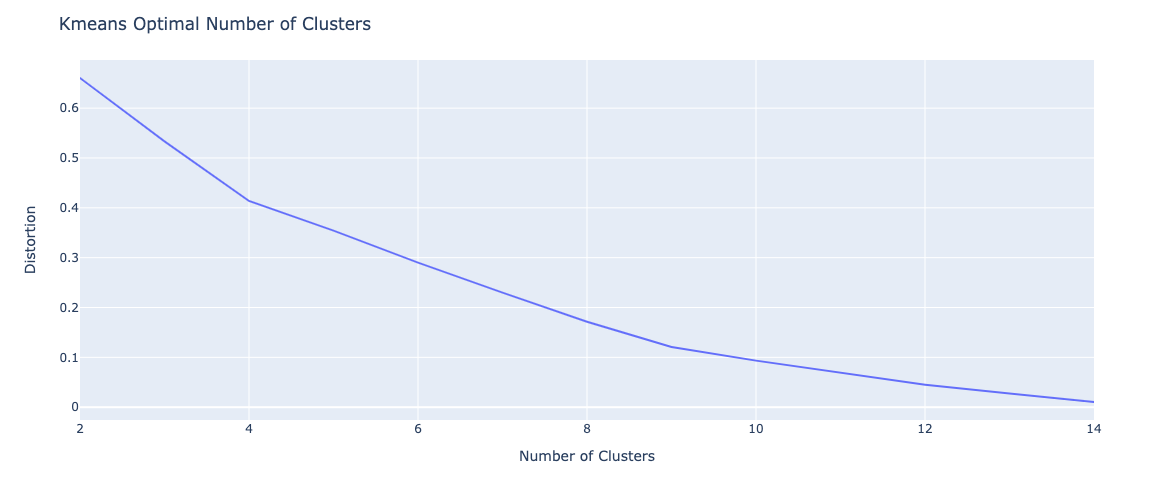

In [17]:
# Series clustering using 'correlation'
method='correlation'
nlags=None
alpha=None
scale=True
scale_method=None
split_method=None
n_clusters=None # providing a value for n_clusters will force that number of clusters to be used
max_clusters=14 # this needs to be < # series
plot=True

covid_clusters =  ts.add_cluster_labels(training, 
                                    ts_settings, 
                                    method=method,
                                    scale=scale,
                                    scale_method=scale_method,
                                    alpha=alpha,
                                    nlags=nlags, 
                                    split_method=split_method,
                                    n_clusters=n_clusters, 
                                    max_clusters=max_clusters, 
                                    plot=plot)

### you can visualize the clusters in two ways:
- Target over time for each cluster
- Dimensionality reduction with coloring for each cluster

/Users/jarred.bultema/test/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/Users/jarred.bultema/test/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




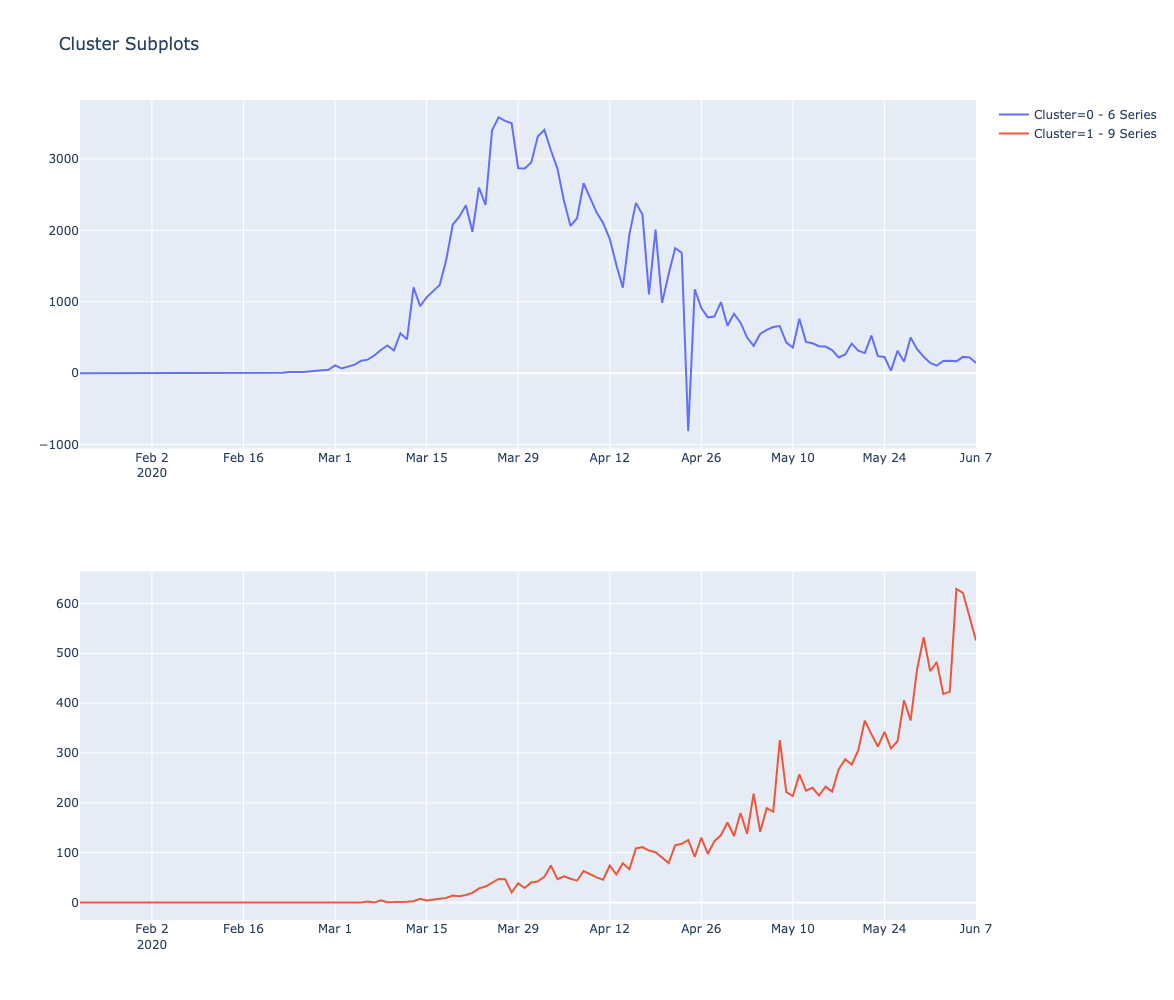

In [18]:
ts.plot_clusters(covid_clusters, ts_settings)

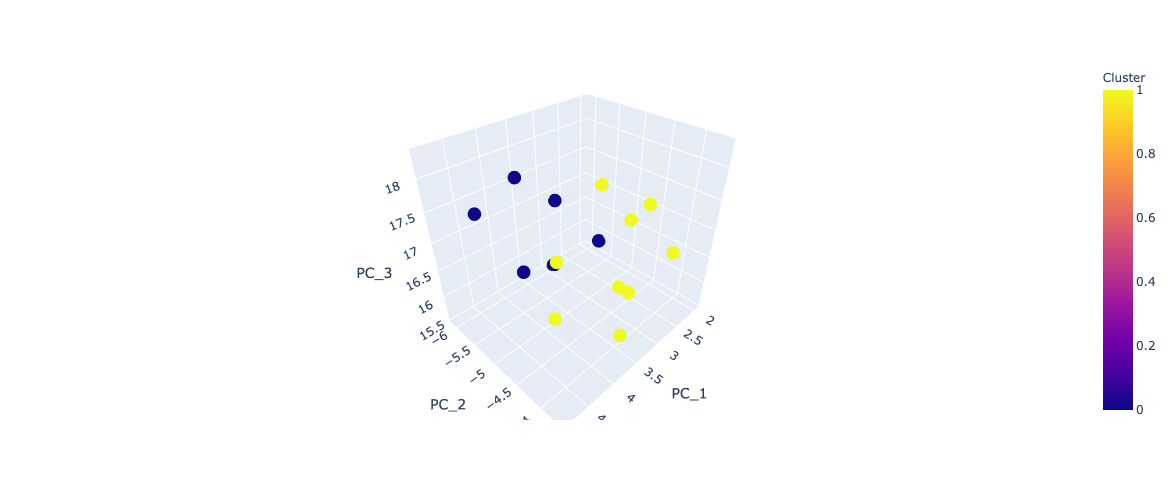

In [19]:
# reshape the dataframe for dimensionality reduction
clusters_t_scaled = ts.reshape_df(covid_clusters, ts_settings, scale= True)

# perform dimensionality reduction and plot the clustered data with labels
ts.plot_UMAP(clusters_t_scaled, covid_clusters, ts_settings)

### Partial Autocorrelation Function (pacf) uses lagged values of the target to determine clusters. 'nlags' controls the number of lagged values generated, and the evaluation of the partial autocorrelation of a series allows for determination of similar time series. This is especially good for data with very strong periodic trends (ex. rotational data from engines, etc)

Testing 2 to 10 clusters
For n_clusters = 2, silhouette score is 0.3280099573665175
For n_clusters = 3, silhouette score is 0.3436891592918215
For n_clusters = 4, silhouette score is 0.31290149775515075
For n_clusters = 5, silhouette score is 0.2499927753359174
For n_clusters = 6, silhouette score is 0.1923686358365031
For n_clusters = 7, silhouette score is 0.1726414400377834
For n_clusters = 8, silhouette score is 0.19943215387296725
For n_clusters = 9, silhouette score is 0.22669239444747255
For n_clusters = 10, silhouette score is 0.218590360045979
optimal n_clusters = 3, max silhouette score is 0.3436891592918215


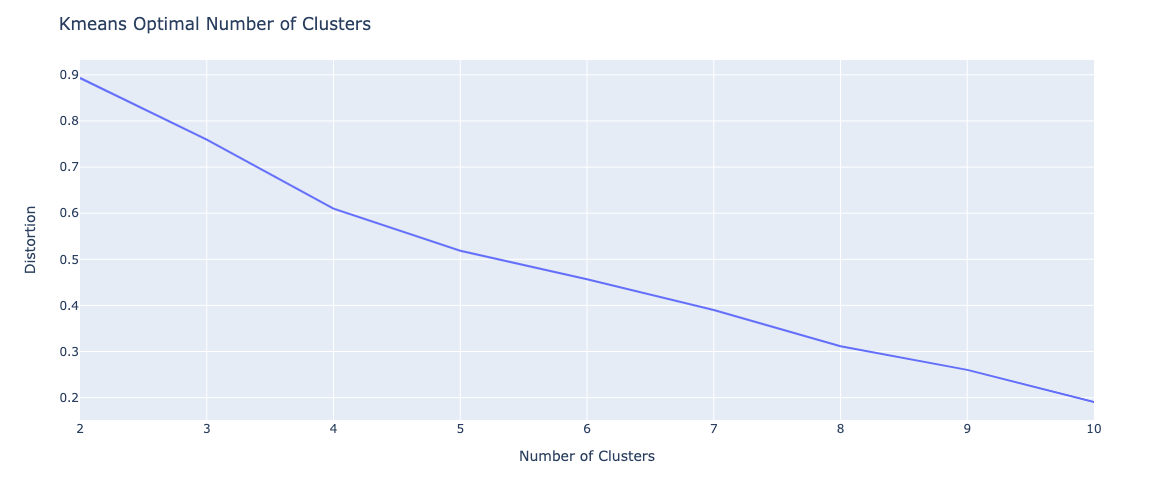

In [20]:
method='pacf'
nlags=7 # pacf method using AR(n) lags. nlags allowed values depend on dataset
alpha=0.025 #Set to None if you want keep raw coefficeints
scale=True
scale_method='normalize' # normalize or min_max
split_method= None # 'rank' or 'quantitles' allowed for 'target' method
n_clusters=None # define explicitly, or allow selection based onb max silhouette score
max_clusters=10 # int or None (# series - 1)
plot=True

covid_clusters =  ts.add_cluster_labels(training, 
                                       ts_settings, 
                                       method=method,
                                       scale=scale,
                                       scale_method=scale_method,
                                       alpha=alpha,
                                       nlags=nlags, 
                                       n_clusters=n_clusters, 
                                       max_clusters=max_clusters, 
                                       plot=plot)


### 'Target' clustering will perform basic analysis of the target variable for a series and either be split by the rank, quantiles or if neither of those split_methods is provided will simply analyze the mean of each series. 

In [21]:
# target 
method='target'
nlags=None
alpha=None 
scale=True
scale_method='normalize'
n_clusters=None
split_method= 'rank' # rank or quantiles
max_clusters=5
plot=True

covid_clusters =  ts.add_cluster_labels(training, 
                                       ts_settings, 
                                       method=method,
                                       scale=scale,
                                       scale_method=scale_method,
                                       alpha=alpha,
                                       nlags=nlags, 
                                       n_clusters=n_clusters, 
                                       split_method = split_method,
                                       max_clusters=max_clusters, 
                                       plot=plot)

------------
# Cluster the series using pACF and a lag of 7

### 3 clusters seems to give results that make sense

In [22]:
method='pacf'
nlags=7 # pacf method using AR(n) lags. nlags allowed values depend on dataset
alpha=0.025 #Set to None if you want keep raw coefficeints
scale=True
scale_method='normalize' # normalize or min_max
split_method= None # 'rank' or 'quantitles' allowed for 'target' method
n_clusters=3 # define explicitly, or allow selection based onb max silhouette score
max_clusters=10 # int or None (# series - 1)
plot=True

clusters =  ts.add_cluster_labels(training, 
                                ts_settings, 
                                method=method,
                                scale=scale,
                                scale_method=scale_method,
                                alpha=alpha,
                                nlags=nlags, 
                                n_clusters=n_clusters, 
                                max_clusters=max_clusters, 
                                plot=plot)

/Users/jarred.bultema/test/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/Users/jarred.bultema/test/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/Users/jarred.bultema/test/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




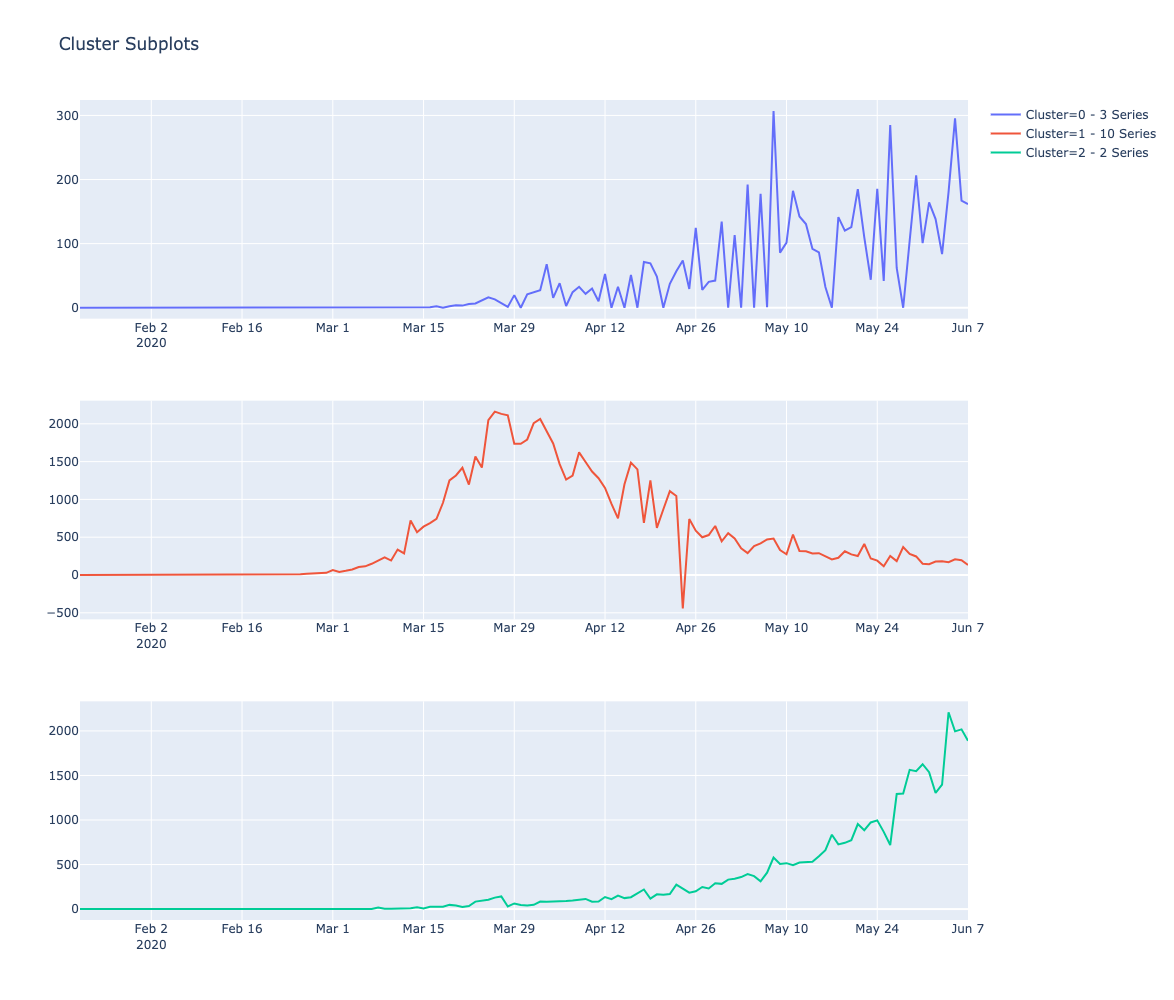

In [23]:
ts.plot_clusters(clusters, ts_settings)

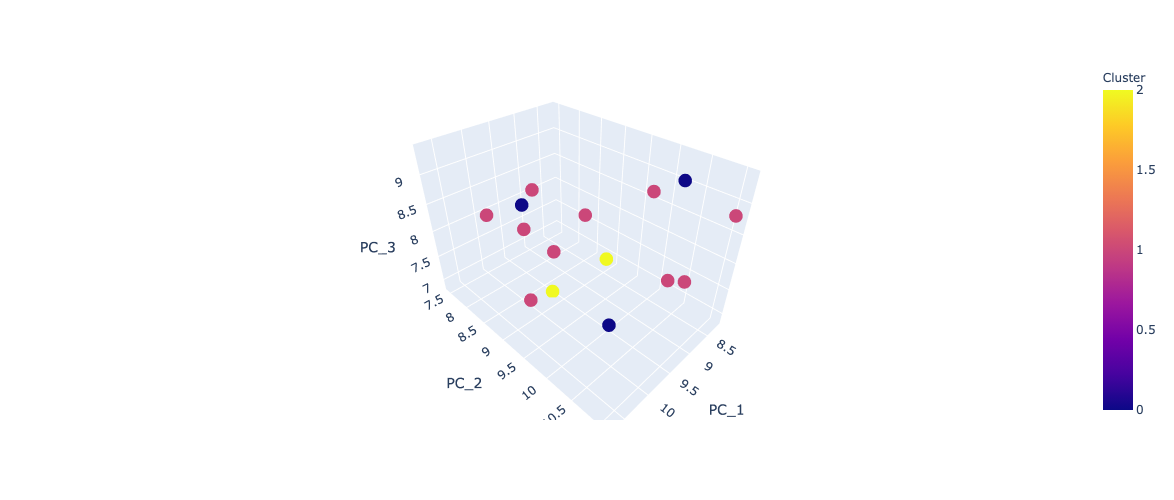

In [24]:
# reshape the dataframe for dimensionality reduction
clusters_t_scaled = ts.reshape_df(clusters, ts_settings, scale= True)

# perform dimensionality reduction and plot the clustered data with labels
ts.plot_UMAP(clusters_t_scaled, clusters, ts_settings)

### These clusters appear to correspond to 'early outbreak' (Cluster 0), 'post first-wave' (Cluster1), and 'mid first-wave' (Cluster 2) that makes logical sense. We will proceed with this strategy.

### at this point, you want to add the cluster-labels to the full dataset that you will use for building projects

In [25]:
# original df
print(covid.shape)

# training df for clustering
print(covid_clusters.shape)

# merge cluster labels
clusters = covid.merge(covid_clusters[['Country/Region','Cluster']], on= 'Country/Region', how= 'left').drop_duplicates()

# check output shape
print(clusters.shape)

(2505, 42)
(2070, 43)
(2505, 43)


--------------
# Cross Series Features

### In this dataset, it may be relevant to add cross series features from the other series in the same clusters

#### - The following function will create custom aggregations across groups
#### - group input is the precise label to be used with a pandas groupby function: df.groupby(group_input)
#### - group accepts multiple column names as inputs if provided in a list
#### - functions must be compatible with pandas df.transform(function) structure, which allows for user-defined functions

In [26]:
# create cross series features automatically
covid_w_clusters = ts.create_cross_series_features(clusters, 
                                             group=['Date','Cluster'], 
                                             cols=[target], 
                                             funcs=['mean','median','std','min','max'])
covid_w_clusters.head(2)

Country/Region  Cumulative_cases  Cumulative_deaths  Daily_cases  \
0        Algeria               0.0                0.0          0.0   
1        Algeria               0.0                0.0          0.0   

   Daily_deaths       DataLevel       Date  Province/State  \
0           0.0  Country/Region 2020-01-22             NaN   
1           0.0  Country/Region 2020-01-23             NaN   

   Confirmed_cases_change  Cumulative_cases_change  Confirmed_deaths_change  \
0                    -1.0                     -1.0                     -1.0   
1                     0.0                      0.0                      0.0   

   Cumulative_deaths_change  \
0                      -1.0   
1                       0.0   

   retail_and_recreation_percent_change_from_baseline  \
0                                                NaN    
1                                                NaN    

   grocery_and_pharmacy_percent_change_from_baseline  \
0                                                NaN   
1                                                NaN   

   parks_percent_change_from_baseline  \
0                                 NaN   
1                                 NaN   

   transit_stations_percent_change_from_baseline  \
0                                            NaN   
1                                            NaN   

   workplaces_percent_change_from_baseline  \
0                                      NaN   
1                                      NaN   

   residential_percent_change_from_baseline  Latest_Population_total  \
0                                       NaN               42228429.0   
1                                       NaN               42228429.0   

   5_year_percent_change_Population_total  Latest_GDP (current US$)  \
0                               10.719147              1.737580e+11   
1                               10.719147              1.737580e+11   

   5_year_percent_change_GDP (current US$)  Latest_GDP growth (annual %)  \
0                               -17.161379                           1.4   
1                               -17.161379                           1.4   

   5_year_percent_change_GDP growth (annual %)  \
0                                        -50.0   
1                                        -50.0   

   Latest_Population_male (% of total population)  \
0                                       50.515732   
1                                       50.515732   

   5_year_percent_change_Population_male (% of total population)  \
0                                            0.05532               
1                                            0.05532               

   Latest_Population ages 65 and above_total  \
0                                  2686782.0   
1                                  2686782.0   

   5_year_percent_change_Population ages 65 and above_total  \
0                                          24.974859          
1                                          24.974859          

   Latest_School enrollment_primary (% gross)  \
0                                   109.88282   
1                                   109.88282   

   5_year_percent_change_School enrollment_primary (% gross)  \
0                                          -8.078095           
1                                          -8.078095           

   Latest_Life expectancy at birth_total (years)  \
0                                         76.693   
1                                         76.693   

   5_year_percent_change_Life expectancy at birth_total (years)  \
0                                           1.363979              
1                                           1.363979              

   Latest_Population_male  5_year_percent_change_Population_male  \
0              21332000.0                              10.780399   
1              21332000.0                              10.780399   

   Latest_Population ages 65 and above (% of total population)  \
0                            

In [27]:
covid_w_clusters.to_csv('../../data/JHU_select_15_clustered.csv', index= None)

----------
# Build DR projects

#### These functions rely heavily on the ts_settings dictionary and the prefix used for the project. Generally you will want to use a unique prefix for the projects that will make it easy to retrieve just the results you want (in case you need to pull projects from a list of all your DR projects)

#### First, the Forecast Distance (FD) and Feature Derivation Windows (FDW) need to be defined. 

In [ ]:
# for NO clustering:
# use PACF clustering with 3 clusters
# build separate projects by FD, FDW, and/or cluster
fdws = [(-7,0), (-15,0), (-28,0), (-35,0)] # typically multiples of a seasonality are a good starting point
fds = [(1,15), (16,30)] # in this case, predicting one month is the goal

projects = ts.create_dr_projects(covid_w_clusters, 
                             ts_settings, 
                             prefix='COVID_daily_cases_tutorial_1', # provide a prefix that will make it easy to search for only these projects
                             split_col= None, 
                             fdws=fdws, 
                             fds=fds, 
                             mode= dr.AUTOPILOT_MODE.QUICK) # FULL_AUTO, MANUAL, or QUICK

In [33]:
# if you want to get this list of projects later, if the variable has been overwritten, 
# if you are doing the modeling/analysis separately, etc...
tag = 'COVID_daily_cases_tutorial_1'

# get only projects with that prefix that completed
# you can get errors if you attempt to run subsequent functions on a list of projects that has uncompleted projects with no models
projects = [x for x in dr.Project.list() if tag in str(x) and x.stage == 'modeling']

In [ ]:
# use PACF clustering with 3 clusters
# build separate projects by FD, FDW, and/or cluster
fdws = [(-7,0), (-15,0), (-28,0), (-35,0)] # typically multiples of a seasonality are a good starting point
fds = [(1,15), (16,30)] # in this case, predicting one month is the goal

projects1 = ts.create_dr_projects(covid_w_clusters, 
                             ts_settings, 
                             prefix='COVID_cases_clustered_tutorial_1', # provide a prefix that will make it easy to search for only these projects
                             split_col= 'Cluster', 
                             fdws=fdws, 
                             fds=fds, 
                             mode= dr.AUTOPILOT_MODE.QUICK) # FULL_AUTO, MANUAL, or QUICK

projects1 = [x for x in projects1 if x.stage == 'modeling']

### You'll notice in the printed outputs of the above function that it will provide you a list of any projects that failed. You may want to re-run those projects specifically, or exclude them if you want to proceede with analysis

### It is very easy to iterate over different FDW and FD and you'll be able to easily see what worked better using other methods/functions

In [44]:
# use PACF clustering with 3 clusters
# build separate projects by FD, FDW, and/or cluster
fds2 = [(1,10),(11,20),(21,30)] # in this case, predicting one month of sales is the goal

projects2 = ts.create_dr_projects(covid_w_clusters, 
                             ts_settings, 
                             prefix='COVID_cases_clustered_tutorial_2', # provide a prefix that will make it easy to search for only these projects
                             split_col= 'Cluster', 
                             fdws=fdws, 
                             fds=fds2, 
                             mode= dr.AUTOPILOT_MODE.QUICK) # FULL_AUTO, MANUAL, or QUICK

projects2 = [x for x in projects2 if x.stage == 'modeling']

Kicking off 36 projects

Building Next Project 
...

Creating project COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-7_Cluster-1 ...
Project COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-7_Cluster-1 was successfully built!

Building Next Project 
...

Creating project COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-7_Cluster-1 ...
Project COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-7_Cluster-1 was successfully built!

Building Next Project 
...

Creating project COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-7_Cluster-1 ...
Project COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-7_Cluster-1 was successfully built!

Building Next Project 
...

Creating project COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-15_Cluster-1 ...
Project COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-15_Cluster-1 was successfully built!

Building Next Project 
...

Creating project COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-15_Cluster-1 ...
Project COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-15_Cluster-1 

## If you previously created these projects and need to get them again (because you reset the kernel, etc), it is simple:

In [34]:
tag1 = 'COVID_cases_clustered_tutorial_1'
tag2 = 'COVID_cases_clustered_tutorial_2'

projects1 = [x for x in dr.Project.list() if tag1 in str(x) and x.stage == 'modeling']

In [35]:
projects2 = [x for x in dr.Project.list() if tag2 in str(x) and x.stage == 'modeling']

--------
# Evaluate DR Projects

### The following section shows many functions for evaluating and comparing the performance of many DR projects

### The common inputs are the list of DR projects, the ts_settings, and outputs from previous functions

In [29]:
%%time
# you need to compute backtests before you can evaluate performance
ts.compute_backtests(projects, n_models=5, data_subset='allBacktests', include_blenders=True, metric='RMSE')
ts.compute_backtests(projects1, n_models=5, data_subset='allBacktests', include_blenders=True, metric='RMSE')
ts.compute_backtests(projects2, n_models=5, data_subset='allBacktests', include_blenders=True, metric='RMSE')

Computing backtests for model 5f6e4ac9684b971241f420a7 in Project COVID_daily_cases_tutorial_1_FD:16-30_FDW:-35_all_series
All available backtests have been submitted for scoring for project COVID_daily_cases_tutorial_1_FD:16-30_FDW:-35_all_series
All available backtests have been submitted for scoring for project COVID_daily_cases_tutorial_1_FD:1-15_FDW:-35_all_series
All available backtests have been submitted for scoring for project COVID_daily_cases_tutorial_1_FD:16-30_FDW:-28_all_series
All available backtests have been submitted for scoring for project COVID_daily_cases_tutorial_1_FD:1-15_FDW:-28_all_series
All available backtests have been submitted for scoring for project COVID_daily_cases_tutorial_1_FD:16-30_FDW:-15_all_series
All available backtests have been submitted for scoring for project COVID_daily_cases_tutorial_1_FD:1-15_FDW:-15_all_series
All available backtests have been submitted for scoring for project COVID_daily_cases_tutorial_1_FD:16-30_FDW:-7_all_series
All av

In [36]:
%%time
# Get the results from completed projects
projects_scores = ts.get_or_request_backtest_scores(projects, 
                                               n_models=5, 
                                               data_subset='allBacktests', 
                                               include_blenders=True, 
                                               metric='RMSE')

projects1_scores = ts.get_or_request_backtest_scores(projects1, 
                                               n_models=5, 
                                               data_subset='allBacktests', 
                                               include_blenders=True, 
                                               metric='RMSE')

projects2_scores = ts.get_or_request_backtest_scores(projects2, 
                                               n_models=5, 
                                               data_subset='allBacktests', 
                                               include_blenders=True, 
                                               metric='RMSE')


Scores for all 8 projects have been computed
Scores for all 24 projects have been computed
Scores for all 36 projects have been computed
CPU times: user 5.38 s, sys: 854 ms, total: 6.24 s
Wall time: 4min 40s


In [37]:
# this isn't particularly relevant if there is only a single DR project for a use-case (i.e. 'projects')
projects2_scores.sample(5)

Project_Name  \
98   COVID_cases_clustered_tutorial_2_FD:11-20_FDW:...   
76   COVID_cases_clustered_tutorial_2_FD:21-30_FDW:...   
163  COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-...   
123  COVID_cases_clustered_tutorial_2_FD:21-30_FDW:...   
45   COVID_cases_clustered_tutorial_2_FD:21-30_FDW:...   

                   Project_ID                  Model_ID  \
98   5f6d03fcddc1ac027217719f  5f6d04dd22a74a85c082e04c   
76   5f6d07a074945901dc2164c8  5f6d09d3a43a2d3fdbe15e69   
163  5f6cf37eddc1ac0272177167  5f6cf4f03f94ebde31687d62   
123  5f6cff18ddc1ac02a317716e  5f6d005b81a800a759738053   
45   5f6d0d9eddc1ac0323176f8e  5f6d10a6b3180760b8f3ae0c   

                                            Model_Type  \
98            eXtreme Gradient Boosted Trees Regressor   
76   Zero-Inflated Light Gradient Boosted Trees Reg...   
163    Ridge Regressor with Forecast Distance Modeling   
123  Performance Clustered eXtreme Gradient Boostin...   
45                                         AVG Blender   

                              Featurelist  Backtest_1_RMSE  Backtest_1_MASE  \
98   With Differencing (average baseline)        238.86132          0.91513   
76                DR Reduced Features M24        152.57585          0.87498   
163                       No Differencing        441.72591          1.01087   
123            With Differencing (latest)        665.47035          0.74578   
45                DR Reduced Features M15        172.12734          0.50190   

     Backtest_1_Theils_U  Backtest_1_SMAPE  Backtest_1_R_Squared  \
98               0.94961          46.49303              -1.50423   
76               0.85266          26.42688              -0.02177   
163              0.76947          76.68149               0.92358   
123              0.53734          88.55277               0.82656   
45               0.46280          51.33674              -0.63965   

                    All_Backtests_RMSE           All_Backtests_MASE  \
98   [238.86132, 354.58045, 192.21773]  [0.91513, 1.10756, 0.51853]   
76   [152.57585, 419.07126, 199.98671]   [0.87498, 0.9936, 0.39729]   
163   [441.72591, 305.1043, 248.71554]  [1.01087, 0.90028, 0.91408]   
123  [665.47035, 374.44548, 311.32852]   [0.74578, 0.5854, 0.59513]   
45   [172.12734, 180.64655, 464.99396]   [0.5019, 0.32654, 0.82799]   

          All_Backtests_Theils_U             All_Backtests_SMAPE  \
98   [0.94961, 1.12605, 0.49837]  [46.49303, 49.10085, 72.09992]   
76   [0.85266, 1.05179, 0.38515]  [26.42688, 68.65396, 75.39625]   
163    [0.76947, 0.787, 0.73981]  [76.68149, 82.53073, 92.30036]   
123  [0.53734, 0.42658, 0.41255]  [88.55277, 85.68683, 90.96389]   
45    [0.4628, 0.33125, 0.71432]  [51.33674, 54.37889, 72.54567]   

            All_Backtests_R_Squared Holdout_RMSE Holdout_MASE  \
98   [-1.50423, -0.32102, -0.17739]         None         None   
76   [-0.02177, -0.84525, -0.27448]      99.9635       0.6106   
163     [0.92358, 0.92241, 0.92553]         None         None   
123     [0.82656, 0.88314, 0.88332]         None         None   
45   [-0.63965, -0.4312, -23.41444]         None         None   

    Holdout_Theils_U Holdout_SMAPE Holdout_R_Squared  
98              None          None              None  
76           0.62197       18.1899          -2.38712  
163             None          None              None  
123             None          None              None  
45              None          None              None

In [38]:
%%time
# get the peformance of all projects that have different FDSw/FDs
# the col_error corresponds to the output of get_or_request_backtest_scores()
# you need to define which column you want to use for analysis
scores_best = ts.filter_best_fdw_scores(projects_scores, col_error='All_Backtests_RMSE')
scores1_best = ts.filter_best_fdw_scores(projects1_scores, col_error='All_Backtests_RMSE')
scores2_best = ts.filter_best_fdw_scores(projects2_scores, col_error='All_Backtests_RMSE')


CPU times: user 36.7 ms, sys: 7.9 ms, total: 44.6 ms
Wall time: 48.7 ms


In [39]:
scores1_best.head()

Project_Name  \
115  COVID_cases_clustered_tutorial_1_FD:1-15_FDW:-...   
91   COVID_cases_clustered_tutorial_1_FD:16-30_FDW:...   
65   COVID_cases_clustered_tutorial_1_FD:1-15_FDW:-...   
60   COVID_cases_clustered_tutorial_1_FD:16-30_FDW:...   
36   COVID_cases_clustered_tutorial_1_FD:1-15_FDW:-...   

                   Project_ID                  Model_ID  \
115  5f6cd468ddc1ac02a3176fc9  5f6cd6e2481ee3718efff652   
91   5f6cdaf3749459026e216336  5f6cdfca05c7c9143eda221f   
65   5f6ce164ddc1ac025b176ff2  5f6ce53fb318071326f3ac7f   
60   5f6ce25eddc1ac025b176ff8  5f6ce614481ee30d2cfff6c3   
36   5f6ce781ddc1ac027217712c  5f6ceac605c7c92ba1da227d   

                                          Model_Type  \
115  Ridge Regressor with Forecast Distance Modeling   
91                                       AVG Blender   
65                                       AVG Blender   
60                                       AVG Blender   
36                                       AVG Blender   

                                      Featurelist  Backtest_1_RMSE  \
115                       DR Reduced Features M30        368.53670   
91                        DR Reduced Features M13        472.14850   
65   With Differencing (nonzero average baseline)        188.54595   
60                        DR Reduced Features M24        168.33684   
36           With Differencing (average baseline)        134.09046   

     Backtest_1_MASE  Backtest_1_Theils_U  Backtest_1_SMAPE  \
115          0.75901              0.55400          76.84976   
91           0.52789              0.40310          84.48013   
65           0.64442              0.61794          35.70533   
60           0.83703              0.84533          29.46333   
36           0.67206              0.75646          29.76589   

     Backtest_1_R_Squared                 All_Backtests_RMSE  \
115               0.94681   [368.5367, 316.35137, 258.56749]   
91                0.91269    [472.1485, 334.66267, 236.5401]   
65               -0.56033  [188.54595, 344.76343, 202.70567]   
60               -0.24377  [168.33684, 356.36964, 186.55152]   
36                0.00494  [134.09046, 163.20736, 148.11908]   

              All_Backtests_MASE       All_Backtests_Theils_U  \
115  [0.75901, 0.83106, 0.78027]     [0.554, 0.70471, 0.6289]   
91   [0.52789, 0.49034, 0.40653]   [0.4031, 0.40753, 0.32649]   
65   [0.64442, 0.81741, 0.79491]  [0.61794, 0.83896, 0.76299]   
60    [0.83703, 0.86416, 0.3797]  [0.84533, 0.98586, 0.37537]   
36   [0.67206, 0.91287, 0.67127]  [0.75646, 0.91376, 0.52352]   

                All_Backtests_SMAPE         All_Backtests_R_Squared  \
115   [76.84976, 77.2671, 80.24474]     [0.94681, 0.91659, 0.91952]   
91   [84.48013, 65.92651, 75.60676]     [0.91269, 0.90665, 0.93265]   
65   [35.70533, 47.33277, 72.92441]  [-0.56033, -0.24888, -0.30937]   
60   [29.46333, 46.44656, 71.06644]  [-0.24377, -0.33438, -0.10899]   
36   [29.76589, 44.61728, 37.39367]   [0.00494, -0.16821, -1.47727]   

    Holdout_RMSE Holdout_MASE Holdout_Theils_U Holdout_SMAPE Holdout_R_Squared  
115         None         None             None          None              None  
91          None         None             None          None              None  
65          None         None             None          None              None  
60          None         None             None          None              None  
36          None         None             None          None              None

In [40]:
%%time
# find the best FDW/FD for each set of projects
# the col_error corresponds to the output of get_or_request_backtest_scores(), i.e. 'project_scores' variable in this tutorial
# you need to define which error column you want to use for analysis
projects_best = ts.filter_best_fdw_projects(projects_scores, projects, col_error='All_Backtests_RMSE')
projects1_best = ts.filter_best_fdw_projects(projects1_scores, projects1, col_error='All_Backtests_RMSE')
projects2_best = ts.filter_best_fdw_projects(projects2_scores, projects2, col_error='All_Backtests_RMSE')

CPU times: user 38.9 ms, sys: 2.83 ms, total: 41.7 ms
Wall time: 39.7 ms


In [41]:
# which FDW works best for each FD and cluster?
projects_best

[Project(COVID_daily_cases_tutorial_1_FD:16-30_FDW:-35_all_series),
 Project(COVID_daily_cases_tutorial_1_FD:1-15_FDW:-28_all_series)]

In [42]:
# which FDW works best for each FD and cluster?
projects1_best

[Project(COVID_cases_clustered_tutorial_1_FD:16-30_FDW:-15_Cluster-3),
 Project(COVID_cases_clustered_tutorial_1_FD:1-15_FDW:-7_Cluster-3),
 Project(COVID_cases_clustered_tutorial_1_FD:16-30_FDW:-15_Cluster-2),
 Project(COVID_cases_clustered_tutorial_1_FD:1-15_FDW:-15_Cluster-2),
 Project(COVID_cases_clustered_tutorial_1_FD:16-30_FDW:-28_Cluster-1),
 Project(COVID_cases_clustered_tutorial_1_FD:1-15_FDW:-7_Cluster-1)]

In [43]:
# which FDW works best for each FD and cluster?
projects2_best

[Project(COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-28_Cluster-3),
 Project(COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-15_Cluster-3),
 Project(COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-7_Cluster-3),
 Project(COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-28_Cluster-2),
 Project(COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-28_Cluster-2),
 Project(COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-15_Cluster-2),
 Project(COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-35_Cluster-1),
 Project(COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-28_Cluster-1),
 Project(COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-28_Cluster-1)]

### Lets compare the overall performance of the various modeling groups

Getting series accuracy...


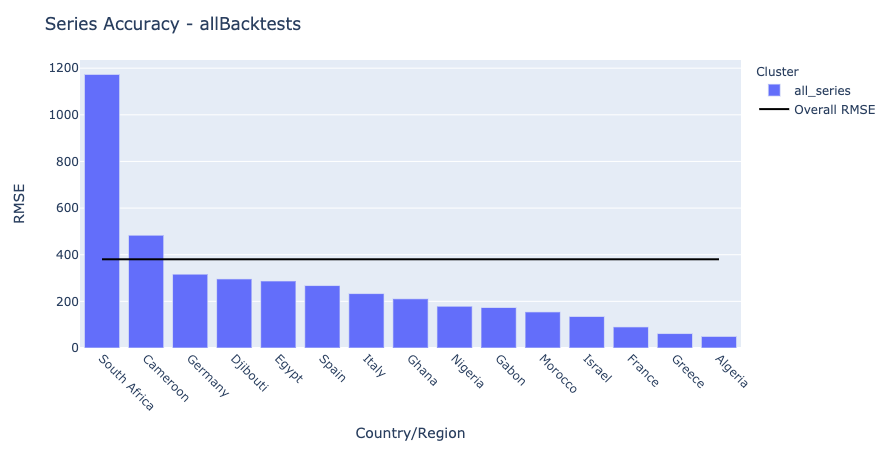

CPU times: user 1.73 s, sys: 55.9 ms, total: 1.79 s
Wall time: 12.4 s


In [44]:
%%time
# in the simplest project there are no clusters, so lets evaluate series-accuracy
# this function takes a few minutes to execute since it is getting lots of predictions from DR
series_acc = ts.get_series_acc(covid_w_clusters, 
                               projects_best, 
                               ts_settings, 
                               data_subset='allBacktests', 
                               include_blenders=True, 
                               metric='RMSE', 
                               acc_calc=ts.rmse)
ts.plot_series_acc(series_acc, ts_settings, data_subset='allBacktests', acc_calc=ts.rmse, n= 50)

### With Clusters and smaller FDs

Getting cluster accuracy...


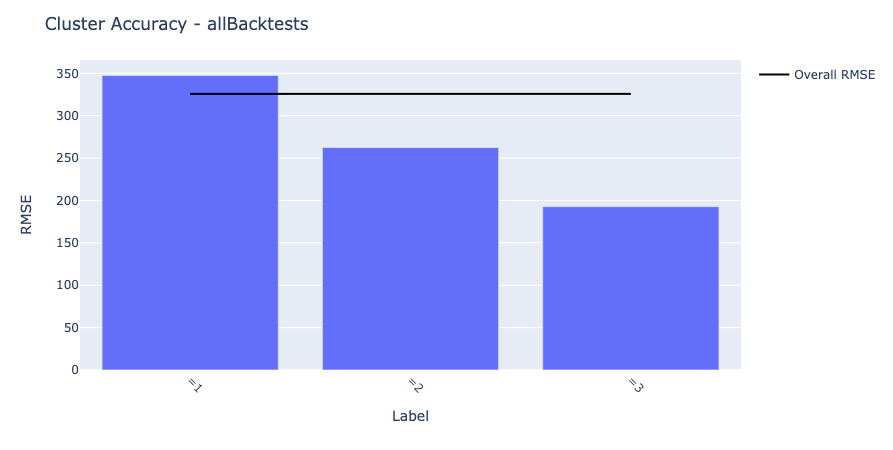

CPU times: user 2.24 s, sys: 46.6 ms, total: 2.28 s
Wall time: 38.8 s


In [45]:
%%time
# you can easily see the performance across clusters and series
# this function takes a few minutes to execute since it is getting lots of predictions from DR
# different metrics can be used, but need to be set in the get_cluster_acc() function using both the 'metric' and 'acc_calc' params
cluster_acc = ts.get_cluster_acc(covid_w_clusters, 
                                 projects1_best, 
                                 ts_settings, 
                                 data_subset='allBacktests', 
                                 include_blenders=False, 
                                 metric='RMSE', 
                                 acc_calc=ts.rmse)
ts.plot_cluster_acc(cluster_acc, ts_settings, data_subset='allBacktests', acc_calc=ts.rmse)

Getting series accuracy...


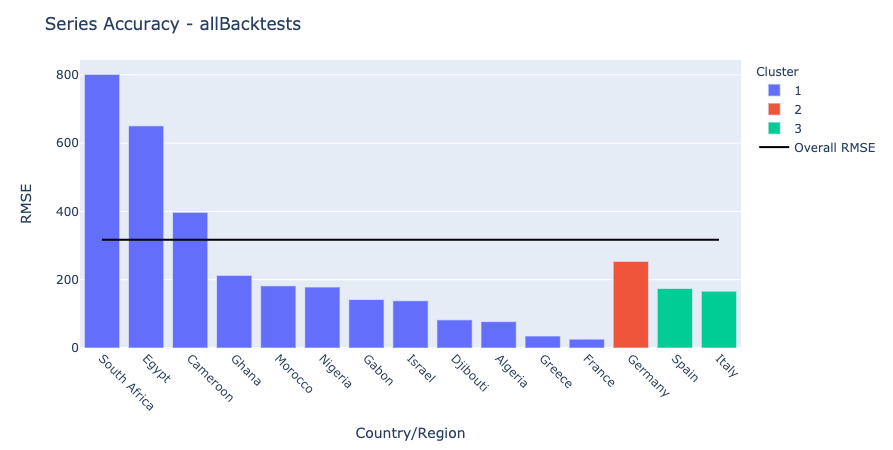

CPU times: user 1.94 s, sys: 35.5 ms, total: 1.98 s
Wall time: 43.7 s


In [46]:
%%time
# this function takes a few minutes to execute since it is getting lots of predictions from DR
series_acc = ts.get_series_acc(covid_w_clusters, 
                               projects1_best, 
                               ts_settings, 
                               data_subset='allBacktests', 
                               include_blenders=True, 
                               metric='RMSE', 
                               acc_calc=ts.rmse)
ts.plot_series_acc(series_acc, ts_settings, data_subset='allBacktests', acc_calc=ts.rmse, n= 50)

Getting series accuracy...


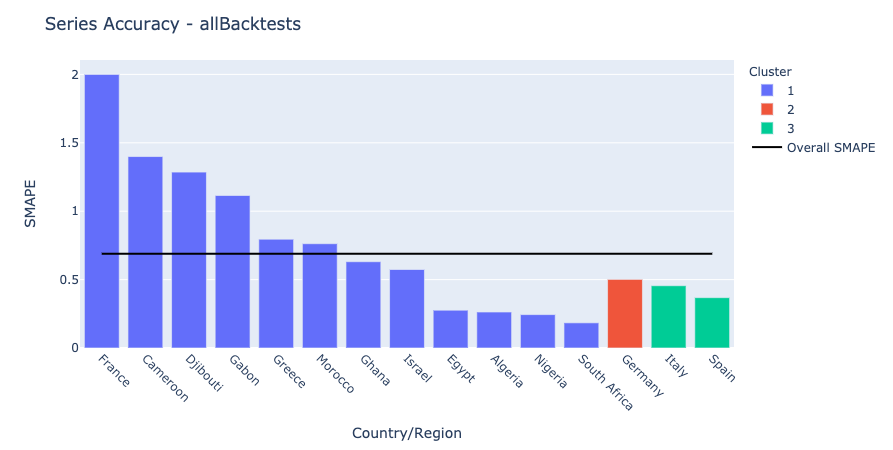

In [47]:
# if you want to change the metric, you need to change those settings in both the get_series_acc() and plot_series_acc() functions
# you can also select different validation periods. currently 'allBacktests' and 'holdout' are supported
series_acc_smape = ts.get_series_acc(covid_w_clusters, 
                               projects1_best, 
                               ts_settings, 
                               data_subset='allBacktests', 
                               include_blenders=True, 
                               metric='SMAPE', 
                               acc_calc=ts.smape)
ts.plot_series_acc(series_acc_smape, ts_settings, data_subset='allBacktests', acc_calc=ts.smape, n= 50)

### With even smaller FDs

Getting cluster accuracy...


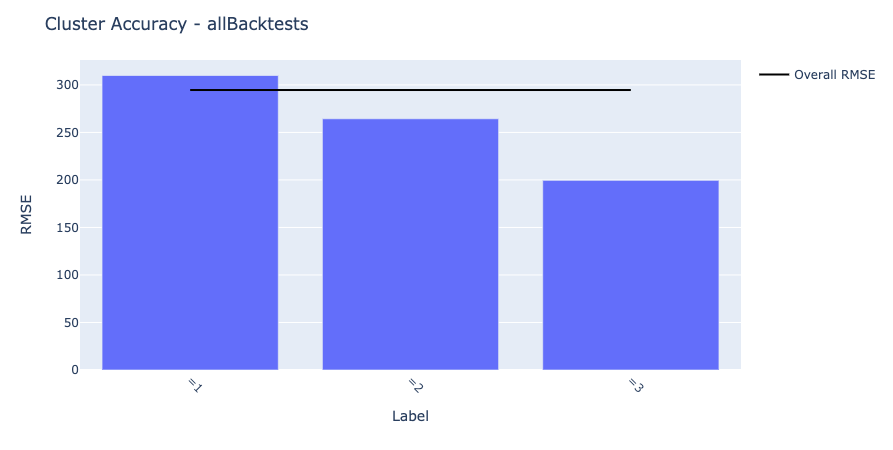

CPU times: user 3.6 s, sys: 78.9 ms, total: 3.68 s
Wall time: 4min 25s


In [48]:
%%time
# you can easily see the performance across clusters and series
# this function takes a few minutes to execute since it is getting lots of predictions from DR
# different metrics can be used, but need to be set in the get_cluster_acc() function using both the 'metric' and 'acc_calc' params
cluster_acc2 = ts.get_cluster_acc(covid_w_clusters, 
                                 projects2_best, 
                                 ts_settings, 
                                 data_subset='allBacktests', 
                                 include_blenders=False, 
                                 metric='RMSE', 
                                 acc_calc=ts.rmse)
ts.plot_cluster_acc(cluster_acc2, ts_settings, data_subset='allBacktests', acc_calc=ts.rmse)

In [49]:
%%time
# this function takes a few minutes to execute since it is getting lots of predictions from DR
series_acc2 = ts.get_series_acc(covid_w_clusters, 
                               projects2_best, 
                               ts_settings, 
                               data_subset='allBacktests', 
                               include_blenders=True, 
                               metric='RMSE', 
                               acc_calc=ts.rmse)
ts.plot_series_acc(series_acc2, ts_settings, data_subset='allBacktests', acc_calc=ts.rmse, n= 50)

Getting series accuracy...


CPU times: user 3.44 s, sys: 70.8 ms, total: 3.51 s
Wall time: 2min 9s


Getting series accuracy...


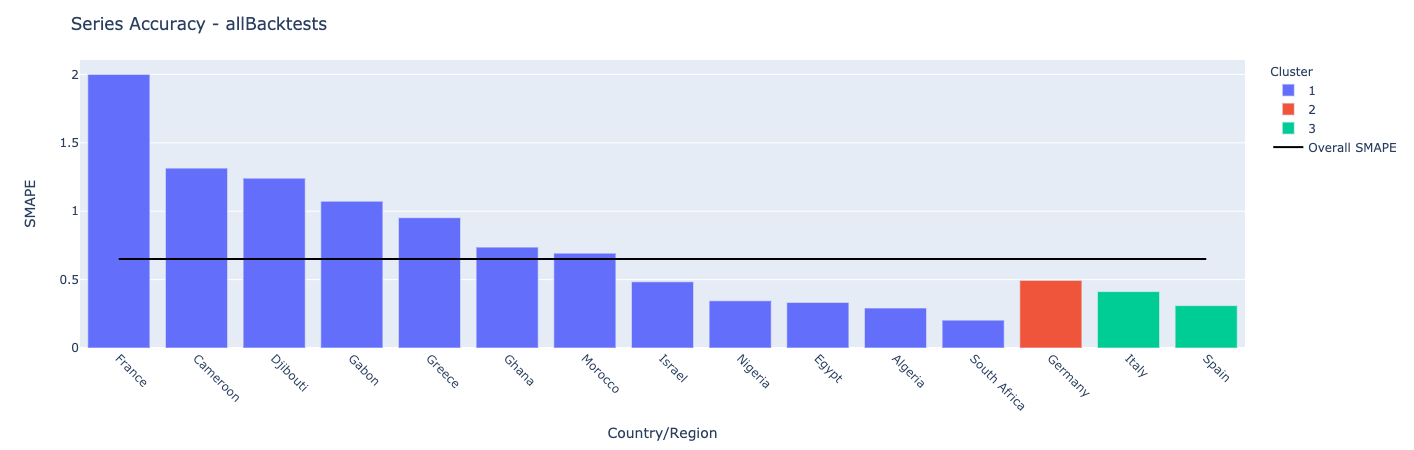

In [50]:
# if you want to change the metric, you need to change those settings in both the get_series_acc() and plot_series_acc() functions
# you can also select different validation periods. currently 'allBacktests' and 'holdout' are supported
series_acc_smape2 = ts.get_series_acc(covid_w_clusters, 
                               projects2_best, 
                               ts_settings, 
                               data_subset='allBacktests', 
                               include_blenders=True, 
                               metric='SMAPE', 
                               acc_calc=ts.smape)
ts.plot_series_acc(series_acc_smape2, ts_settings, data_subset='allBacktests', acc_calc=ts.smape, n= 50)

Getting series accuracy...


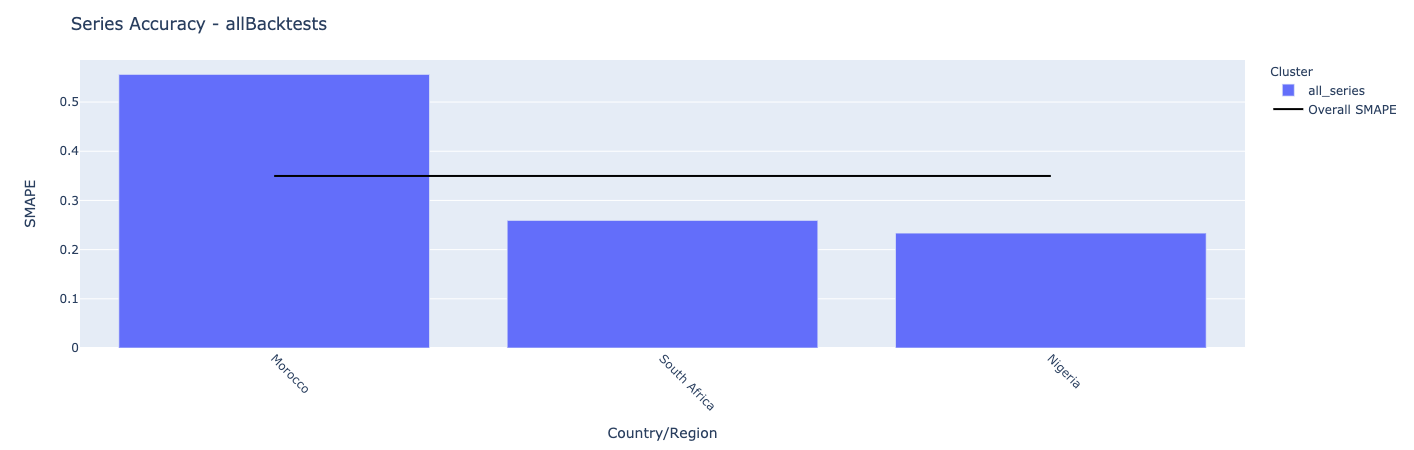

In [51]:
# if you want to analyze only a portion of the data, then just pass in a slice of that dataframe
africa_3_countries = ['Nigeria', 'Morocco', 'South Africa']
africa_3 = covid_w_clusters[covid_w_clusters['Country/Region'].isin(africa_3_countries)]
series_acc_smape = ts.get_series_acc(africa_3, 
                               projects_best, 
                               ts_settings, 
                               data_subset='allBacktests', 
                               include_blenders=True, 
                               metric='SMAPE', 
                               acc_calc=ts.smape)
ts.plot_series_acc(series_acc_smape, ts_settings, data_subset='allBacktests', acc_calc=ts.smape, n= 50)

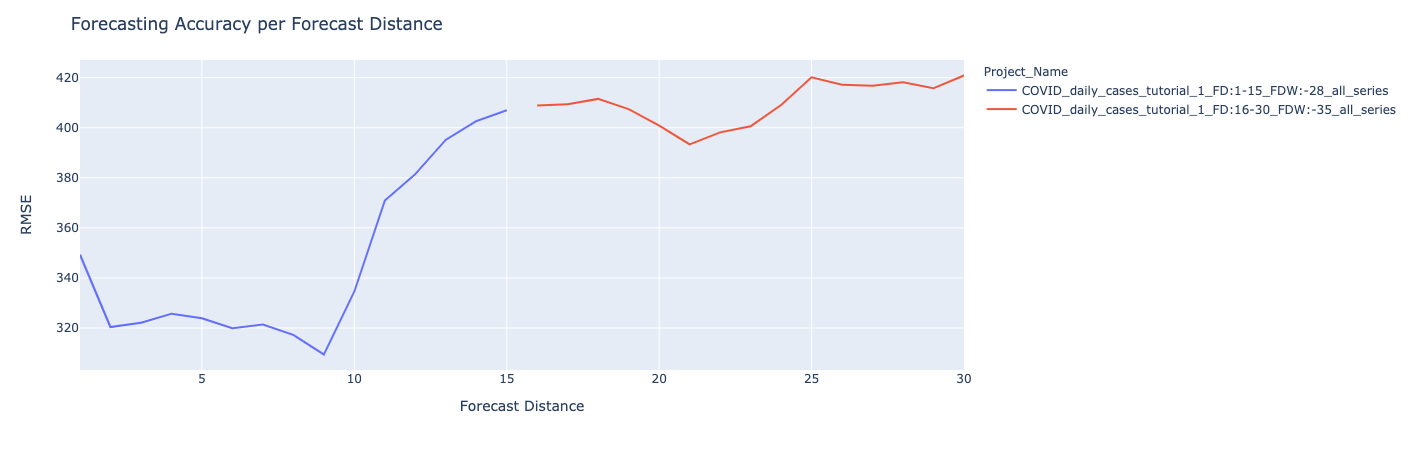

In [52]:
# Project
# using the outputs from the above functions, you can get the Accuracy by FD for all projects (even when multiple FDs are required)
# you can define the metric and data_subset to be used. 'allBacktests' and 'holdout' are allowed for data_subset
ts.plot_fd_accuracy_by_cluster(covid_w_clusters, projects_scores, projects_best, ts_settings, data_subset='allBacktests', metric='RMSE')

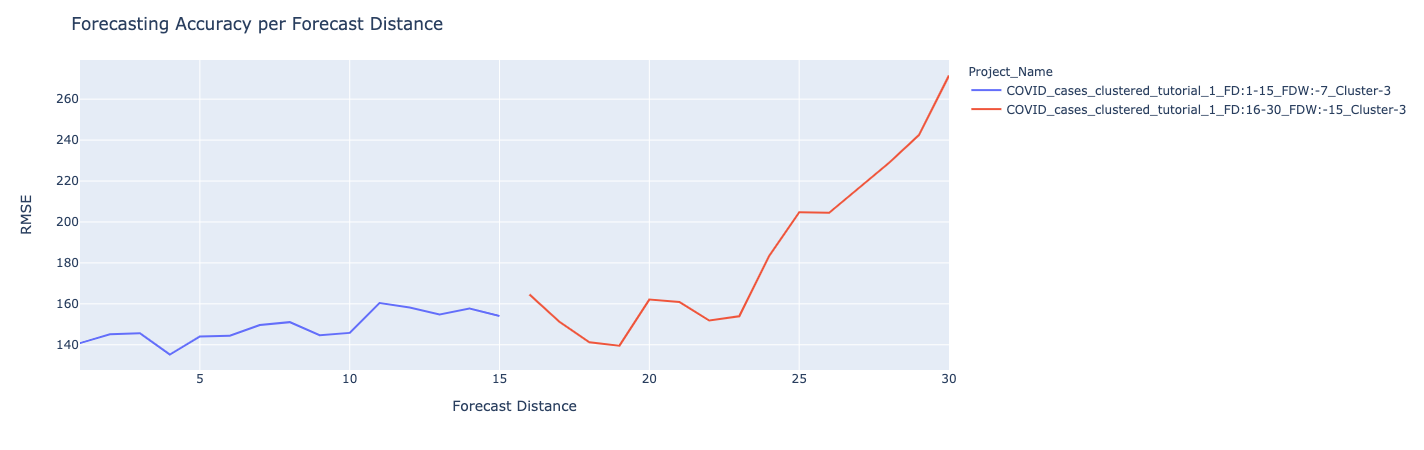

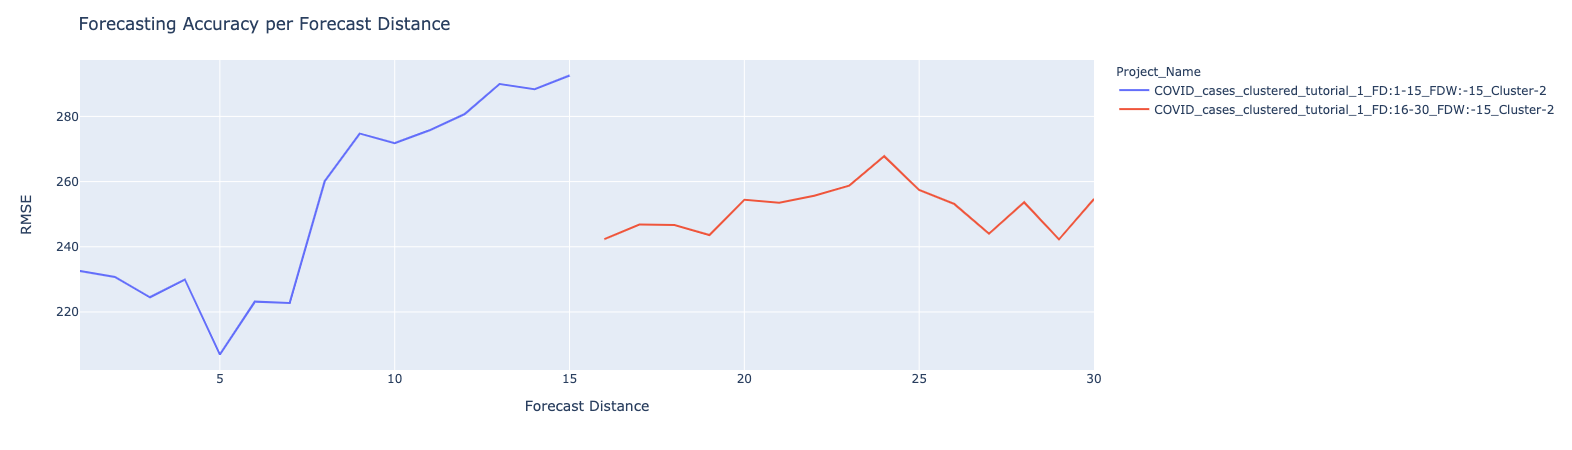

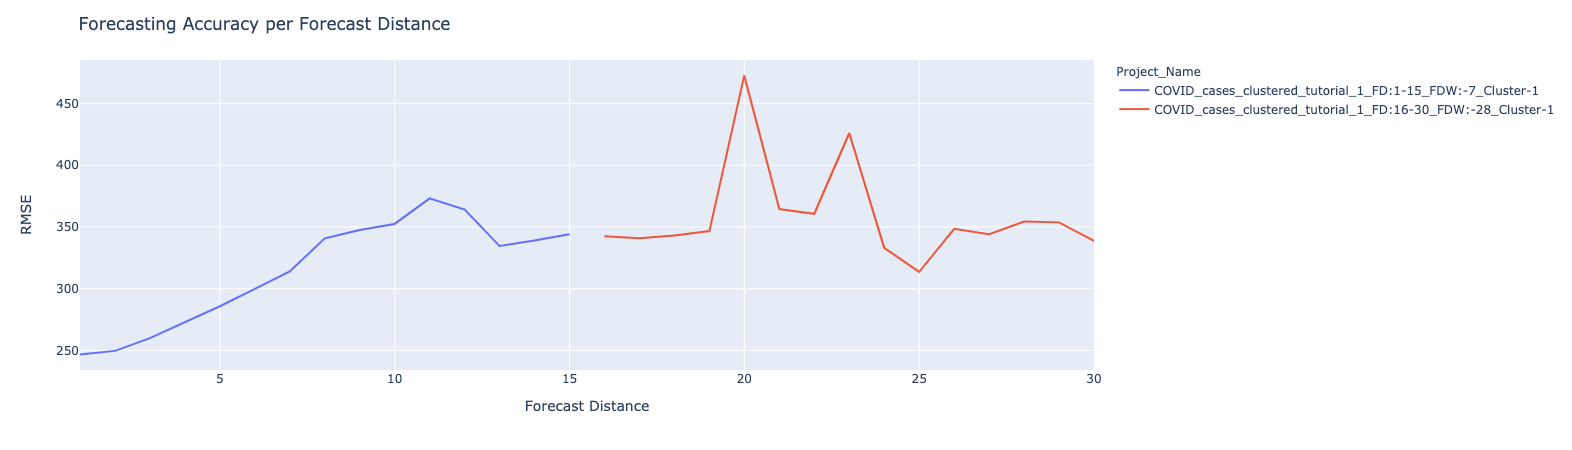

In [53]:
# Project 1
# here we see that more FDs are used
ts.plot_fd_accuracy_by_cluster(covid_w_clusters, projects1_scores, projects1_best, ts_settings, data_subset='allBacktests', metric='RMSE')

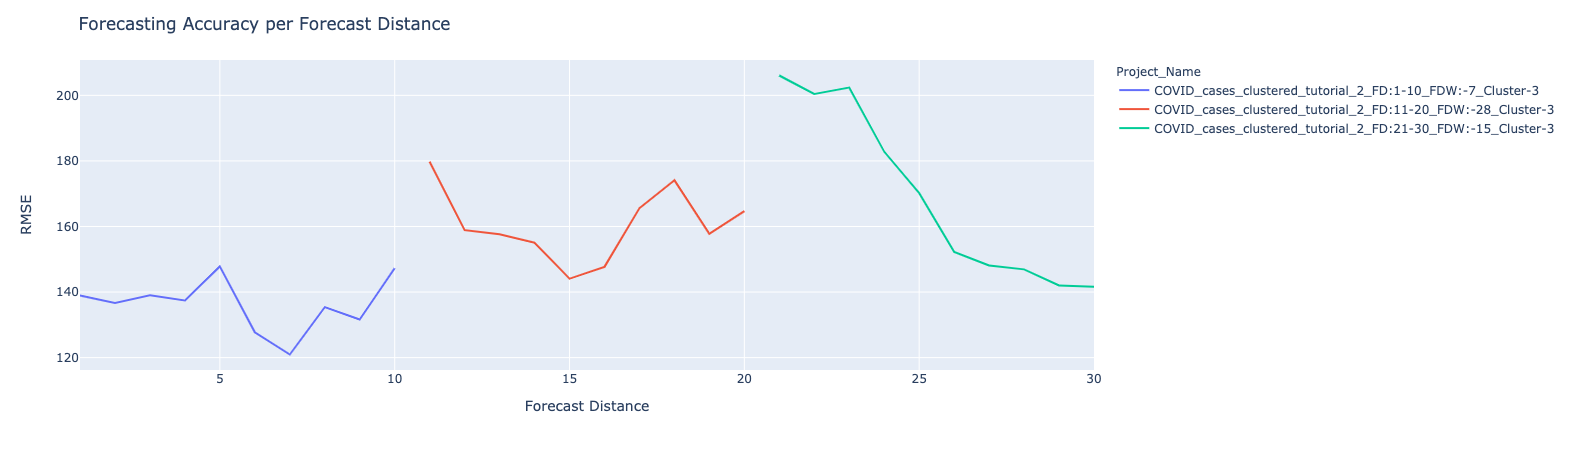

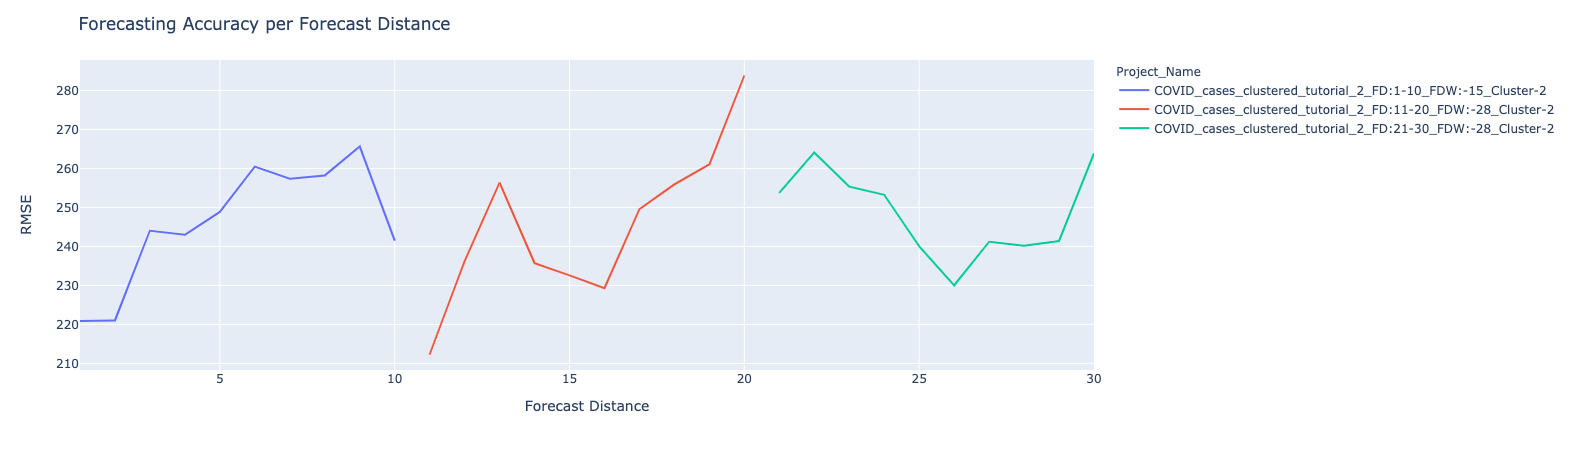

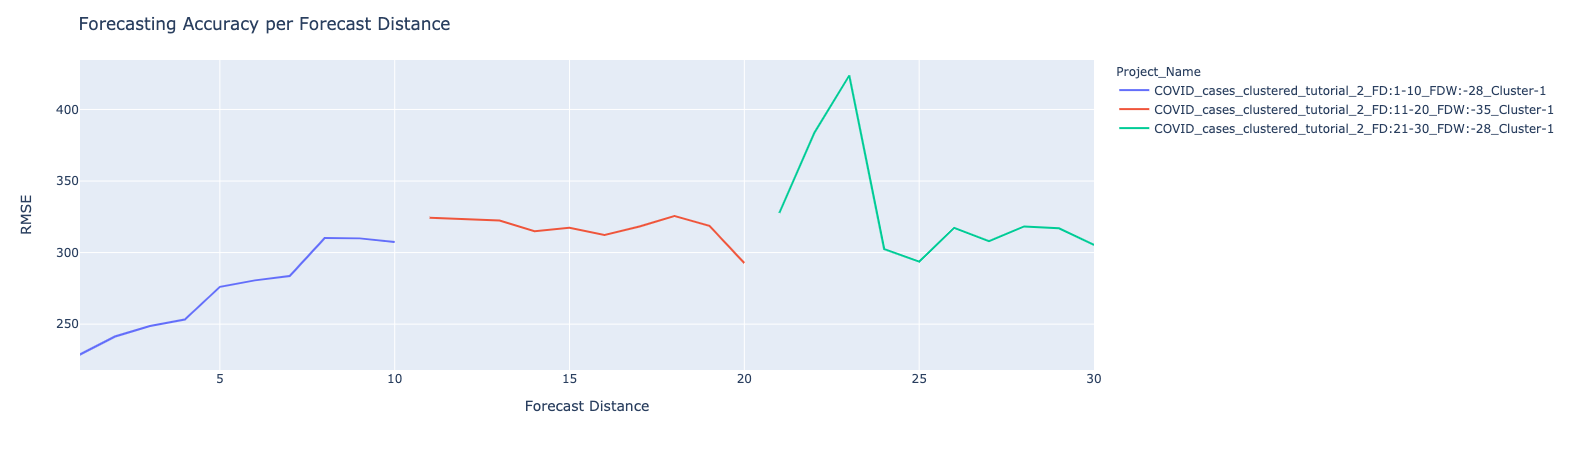

In [54]:
# Project 2
# here we see that more FDs are used
ts.plot_fd_accuracy_by_cluster(covid_w_clusters, projects2_scores, projects2_best, ts_settings, data_subset='allBacktests', metric='RMSE')

### We see that there are certainly differences in performance of clusters over time, and that potentially can be improved through addiitonal modeling. 

### The most complex approach doesn't appear to yield much benefit yet, but we'll continue with only that approach to demonstrate that subsequent steps function identically regardless of the number and complexity of underlying DataRobot projects

-----------------
# Retrain models on reduced features

### To potentially improve performance, models can be retrained on a reduced feature set. Model ranking by Backtest or Holdout data is available, and requires no additional modification of the inputs.

## Different strategies
- single-pass retraining that selects features that combine to give some threshold of total feature impact
- multi-pass retraining where iteratively fewer features (based on threshold of total feature impact) are used to train models and evaluate performance

### Lets start by quickly retraining on a reduced feature set for all clusters and see if we get much performance lift across all models at a single threshold

In [49]:
%%time
# Create a new reduced features feature list per top model and retrain
ts.train_reduced_features_models(projects2_best, n_models=1, threshold=0.9, data_subset='allBacktests', include_blenders=False, metric='RMSE')

# you can add the compute and wait for functions if you want results immediately
ts.wait_for_jobs_to_process(projects2_best)
ts.compute_backtests(projects2_best, n_models=5, data_subset='allBacktests', include_blenders=True, metric='RMSE')
ts.wait_for_jobs_to_process(projects2_best)

# you notice in the output that some projects cannot retrain models, more on this below

Applying this threshold would result in a featurelist with no features
422 client error: {'message': 'Feature list named Top 12 features M15 already exists'}
422 client error: {'message': 'Feature list named Top 4 features M9 already exists'}
Applying this threshold would result in a featurelist with no features
422 client error: {'message': 'Feature list named Top 1 features M59 already exists'}
422 client error: {'message': 'Feature list named Top 19 features M15 already exists'}
422 client error: {'message': 'Feature list named Top 36 features M13 already exists'}
422 client error: {'message': 'Feature list named Top 29 features M13 already exists'}
422 client error: {'message': 'Feature list named Top 1 features M187 already exists'}
All jobs have finished processing...
All available backtests have been submitted for scoring for project COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-28_Cluster-3
All available backtests have been submitted for scoring for project COVID_cases_cluster

### The other option is to do iterative feature reduction for a single project or for many projects

In [50]:
%%time
# run this for a single project
# note: these have already been run, so the output errors shown below are associated with these feature lists already having been computed
one_project = ts.test_feature_selection(covid_w_clusters, projects2_best[-1:], ts_settings, threshold_range= (0.4, 1.0), step_size = 0.2)

422 client error: {'message': 'Feature list named Top 1 features M187 already exists'}
Applying this threshold would result in a featurelist with no features
Applying this threshold would result in a featurelist with no features
CPU times: user 1.46 s, sys: 54.7 ms, total: 1.51 s
Wall time: 1min


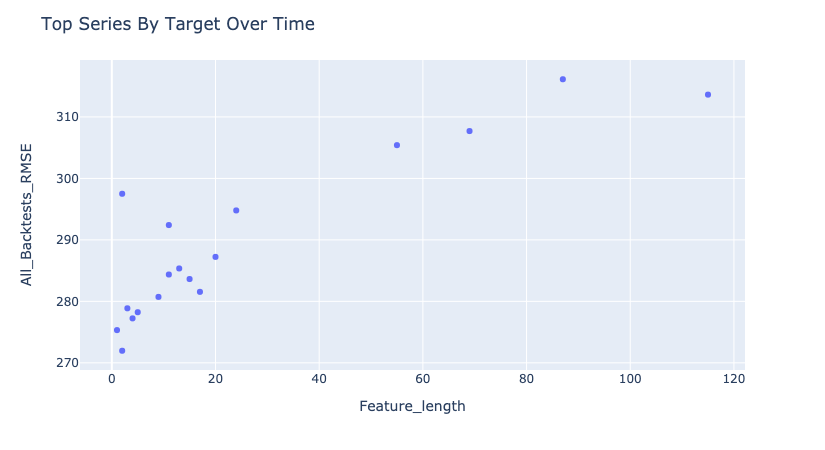

CPU times: user 78.9 ms, sys: 6.43 ms, total: 85.4 ms
Wall time: 92.8 ms


In [51]:
%%time
# plot the results
# not very interesting or helpful in this case
ts.plot_featurelist_learning_curve(one_project, data_subset= 'allBacktests', metric= 'RMSE')


## *** Note on retraining with reduced feature lists for some blueprints

#### - Not all blueprints will support retraining on reduced feature lists if required features are dropped from the feature lists. This occurs commonly when a required naive-baseline feature is dropped from a feature lists. Zero-inflated models and VAR models appears to results in these errors as well.

#### - By default, these functions will take the highest-ranked non-blender model on the leaderboard. Optionally, you can put the leaderboard rank (starting from 1) as a parameter (model_rank= n) and it will take the number 'n' ranked model for feature selection testing. Zero-inflated models generally cannot be used for this process, and there may be other, unknown blueprint-specific interactions or limitations.

In [73]:
# get a model based on leaderboard rank
ts.get_ranked_model(project= projects2_best[-1], model_rank= 4, metric= 'RMSE', data_subset= 'allBacktests')

[DatetimeModel('Ridge Regressor with Forecast Distance Modeling')]

In [53]:
# the test_feature_selection() function allows you to input model-rank to retrain the model of your choice

# test_feature_selection()

#     '''
#     df: pandas df
#     projects: list
#         list of DataRobot projects for feature list selection
#     ts_settings: dict
#         Parameters for time series project
#     n_models: int
#         number of models to generate feature lists from
#     data_subset: str
#         Choose from either holdout or allBacktests
#     metric: str
#         Metric to be used for sorting the leaderboard, if None uses project metric
#     threshold_range: tuple of np.floats (optional)
#         upper and lower bounds of threshold for feature selection, percentage of cumulate feature impact
#     step_size: np.float (optional)
#         step-size across threshold-range
#     model_rank: int (optional)
#         None if top model, model leaderboard rank if any model other than top desired
#     --------
#     Returns:
#     Pandas DataFrame
#     '''

In [54]:
projects2_best[-1].get_leaderboard_ui_permalink()

'https://app.datarobot.com/projects/5f6cf7acddc1ac02a3177130/models'

In [55]:
%%time
# run this for a single project with a model-rank specified
# note: these have already been run, so the output errors shown below are associated with these feature lists already having been computed
one_project = ts.test_feature_selection(covid_w_clusters, projects2_best[-1:], ts_settings, threshold_range= (0.4, 1.0), step_size = 0.05, model_rank= 4)

Training Ridge Regressor with Forecast Distance Modeling on Featurelist Top 5 features M204
Training Ridge Regressor with Forecast Distance Modeling on Featurelist Top 4 features M204
422 client error: {'message': 'Feature list named Top 4 features M204 already exists'}
422 client error: {'message': 'Feature list named Top 4 features M204 already exists'}
422 client error: {'message': 'Feature list named Top 4 features M165 already exists'}
Training Ridge Regressor with Forecast Distance Modeling on Featurelist Top 3 features M204
422 client error: {'message': 'Feature list named Top 3 features M204 already exists'}
Training Ridge Regressor with Forecast Distance Modeling on Featurelist Top 2 features M204
Training Ridge Regressor with Forecast Distance Modeling on Featurelist Top 1 features M233
Applying this threshold would result in a featurelist with no features
Applying this threshold would result in a featurelist with no features
Applying this threshold would result in a featurel

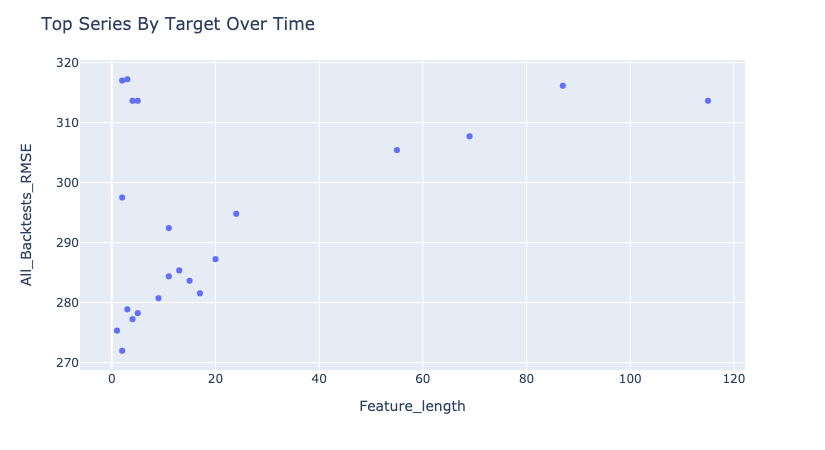

CPU times: user 77.4 ms, sys: 4.26 ms, total: 81.7 ms
Wall time: 78 ms


In [56]:
%%time
# plot the results
# not very interesting or helpful in this case
# you can see multiple points for 3-length featurelists, because of all of the above runs
ts.plot_featurelist_learning_curve(one_project, data_subset= 'allBacktests', metric= 'RMSE')

### If desired, you can perform this on all the projects at once

In [ ]:
%%time
# perform this for all of the projects
# you see some errors here because I've already run this feature reduction
projects2_reduced = ts.run_feature_selection_projects(covid_w_clusters, projects2_best, ts_settings, threshold_range= (0.3, 0.9), step_size = 0.1, plot= False)
projects2_reduced.shape

In [ ]:
%%time
# sometimes you see strong effects from reducing features, here not so much
ts.plot_all_featurelist_curves(projects2_reduced, ts_settings, data_subset= 'allBacktests', metric= 'RMSE')

----------
# Train Timeseries blenders



In [68]:
%%time
# You can also create time-series blenders for many projects
# either explicitly define models for each project within a list: list of lists where each-sublist contains the model-ids that correspond to the project with the same index in the project list
# or select how many of the top-models you want DataRobot to automatically blend
ts.train_timeseries_blender_projects(projects2_best, models= None, n_models= 3, blender_method= 'FORECAST_DISTANCE_ENET')


Creating Forecast Distance Enet blender using 3 models from COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-28_Cluster-3 ... 
Creating Forecast Distance Enet blender using 2 models from COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-15_Cluster-3 ... 
Creating Forecast Distance Enet blender using 2 models from COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-7_Cluster-3 ... 
Creating Forecast Distance Enet blender using 2 models from COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-28_Cluster-2 ... 
Creating Forecast Distance Enet blender using 3 models from COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-28_Cluster-2 ... 
Creating Forecast Distance Enet blender using 2 models from COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-15_Cluster-2 ... 
Creating Forecast Distance Enet blender using 2 models from COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-35_Cluster-1 ... 
Creating Forecast Distance Enet blender using 2 models from COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-28_Cluster-1 ... 
Cre

In [69]:
%%time
# You can also create time-series blenders for many projects
# either explicitly define models for each project within a list: list of lists where each-sublist contains the model-ids that correspond to the project with the same index in the project list
# or select how many of the top-models you want DataRobot to automatically blend
ts.train_timeseries_blender_projects(projects2_best, models= None, n_models=35, blender_method= 'FORECAST_DISTANCE_AVG')


Creating Forecast Distance Avg blender using 24 models from COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-28_Cluster-3 ... 
Creating Forecast Distance Avg blender using 25 models from COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-15_Cluster-3 ... 
Creating Forecast Distance Avg blender using 25 models from COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-7_Cluster-3 ... 
Creating Forecast Distance Avg blender using 19 models from COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-28_Cluster-2 ... 
Creating Forecast Distance Avg blender using 19 models from COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-28_Cluster-2 ... 
Creating Forecast Distance Avg blender using 19 models from COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-15_Cluster-2 ... 
Creating Forecast Distance Avg blender using 28 models from COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-35_Cluster-1 ... 
Creating Forecast Distance Avg blender using 25 models from COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-28_Cluster-1 ... 
Cre

--------
# Run the Repo...

### When all else fails and you've got time, then you can consider running many models from the repository. By default, this function will use the featurelist from the DataRobot recommended blueprint. If you want to be 'insane' (insane = True), you can run the repo on the featurelist from the top-5 blueprints on the leaderboard.

In [74]:
# use a sledgehammer...
# the code runs quite fast, and then you have to wait for all of the blueprints to train
# n_bps allows you to only take n-bps in alphabetical order
# set n_bps = None to run the whole repo for each feature list
# some models take extremely long to run or are only very situationally useful
# you can exclude any type of model by using a unique name-fragment of that model/blueprint
ts.run_repository_models(projects2_best, n_bps= None, insane= False, exclude= ['Mean', 'Eureqa', 'Keras', 'VARMAX'])

Attemping training of 61 blueprints in COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-28_Cluster-3 ...
7 new blueprints were trained
54 blueprints were unable to train or had an error

Attemping training of 61 blueprints in COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-15_Cluster-3 ...
56 new blueprints were trained
5 blueprints were unable to train or had an error

Attemping training of 61 blueprints in COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-7_Cluster-3 ...
56 new blueprints were trained
5 blueprints were unable to train or had an error

Attemping training of 36 blueprints in COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-28_Cluster-2 ...
31 new blueprints were trained
5 blueprints were unable to train or had an error

Attemping training of 36 blueprints in COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-28_Cluster-2 ...
31 new blueprints were trained
5 blueprints were unable to train or had an error

Attemping training of 36 blueprints in COVID_cases_clustered_tutorial_2_FD:1-

In [76]:
# once you've run all of these new models, you need to compute and retrieve the backtest performance metrics
ts.compute_backtests(projects2_best, n_models=5, data_subset='allBacktests', include_blenders=True, metric='RMSE')
projects2_scores = ts.get_or_request_backtest_scores(projects2_best, 
                                               n_models=5, 
                                               data_subset='allBacktests', 
                                               include_blenders=True, 
                                               metric='RMSE')
scores2_best = ts.filter_best_fdw_scores(projects2_scores, col_error='All_Backtests_RMSE')
projects2_best = ts.filter_best_fdw_projects(projects2_scores, projects2, col_error='All_Backtests_RMSE')


Computing backtests for model 5f7149fa083a3020f9e24316 in Project COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-28_Cluster-3
Computing backtests for model 5f7151289a117b216d2d830d in Project COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-28_Cluster-3
All available backtests have been submitted for scoring for project COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-28_Cluster-3
Computing backtests for model 5f7149fe9a117b20c12d8495 in Project COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-15_Cluster-3
Computing backtests for model 5f715168083a302119e2448c in Project COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-15_Cluster-3
Computing backtests for model 5f71515b684b972171f42176 in Project COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-15_Cluster-3
Computing backtests for model 5f71514e684b972182f41ff9 in Project COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-15_Cluster-3
All available backtests have been submitted for scoring for project COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-1

----------------
# Getting training predictions

### In the model evaluation and interation process, you may want the training predictions. These can easily be obtained via a function 'get_preds_and_actuals':

In [78]:
%%time
# get predictions for all series
# this function can take a while to run
test_predictions = ts.get_preds_and_actuals(df= covid_w_clusters, projects= projects2_best, ts_settings= ts_settings, include_blenders= True, metric= 'RMSE')

CPU times: user 3.17 s, sys: 482 ms, total: 3.65 s
Wall time: 6min 34s


## It may also be relevant to plot the actuals and predictions.

####  The following 'plot_preds_and_actuals()' function can plot the average across all series, the top series, a named series, plotting individual forecast distances, and allows for control over the aggregation of predictions for a single date from forecast distance predictions

Getting series predictions from DataRobot...


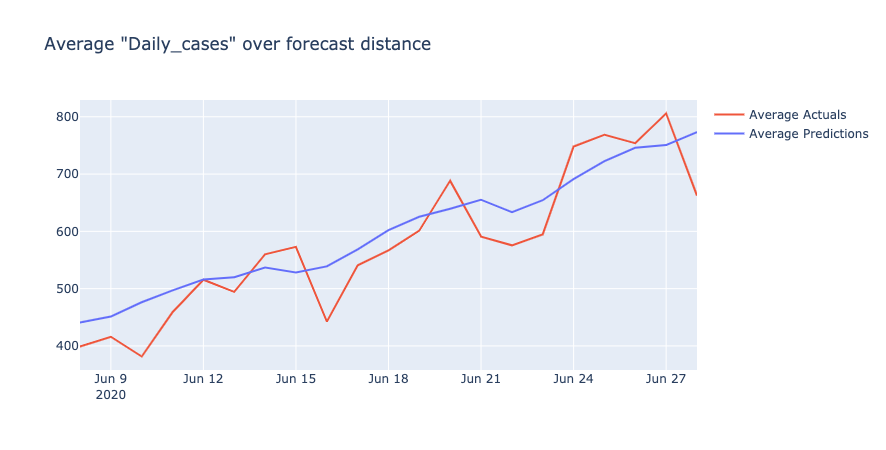

CPU times: user 3.11 s, sys: 342 ms, total: 3.46 s
Wall time: 2min 33s


In [79]:
%%time
# plot the average for all series
# this function also takes a while to run because it is directly pulling preds and actuals from DR
# eventually I need to create a version that uses the above predictions file
ts.plot_preds_and_actuals(covid_w_clusters, projects2_best, ts_settings, fd_range=None, fd_agg= 'mean', fd= None, average= True, series_name= None, top=True, data_subset= 'allBacktests', include_blenders=True, metric= None, acc_calc=ts.rmse)

### There are lots of options for this plotting function.
#### Currently (almost) the only thing it doesn't do is plot out using FD counting up (i.e. FP+1 = FD1, FP+2 = FD2, etc)
#####  (There is code to do ^ from Justin S., but I haven't tested or implemented it yet.)

### plot_preds_and_actuals(
    df, 
    projects, 
    ts_settings, 
    fd_range=None, 
    fd_agg= 'mean', 
    fd= None, 
    average= True, 
    series_name= None, 
    top=None, 
    data_subset= 'allBacktests', 
    include_blenders=False, 
    metric= None, 
    acc_calc=rmse):

    """
    Get series-level and overall accuracy across multiple DataRobot projects

    df: pandas df
    projects: list
        DataRobot project object(s)
    ts_settings: dict
        Parameters for time series project
    fd_range: tuple of ints
        FD start and stop for plotting, None will select all FD
    fd_agg: str
        Aggregation of multiple predictions for a date, accepts 'min', 'max', 'mean'
    fd: int
        Specify FD to plot predictions vs actuals using only that FD
    average: bool
        If plotting average values or individual series
    series_name: str
        Series name (str) to plot
    top: bool
        Plot highest or lowest ordered series by mean target value
    data_subset: str
        Valid values are either holdout or allBacktests
    include_backtests: boolean (optional)
        Controls whether blender models are considered
    metric: str (optional)
        Project metric used to sort the DataRobot leaderboard
        Choose from list of 'MASE', 'RMSE', 'MAPE', 'SMAPE', 'MAE', 'R Squared', 'Gamma Deviance',
                            'SMAPE', 'Tweedie Deviance', 'Poisson Deviance', or 'RMSLE'
    acc_calc: function
        Function to calculate row-level prediction accuracy. Choose from mae, rmse, mape, smape, gamma, poission, and tweedie
        
    Returns:
    --------
    Plotly lineplot
    """

Getting series predictions from DataRobot...
Plotting series actuals and predictions ...


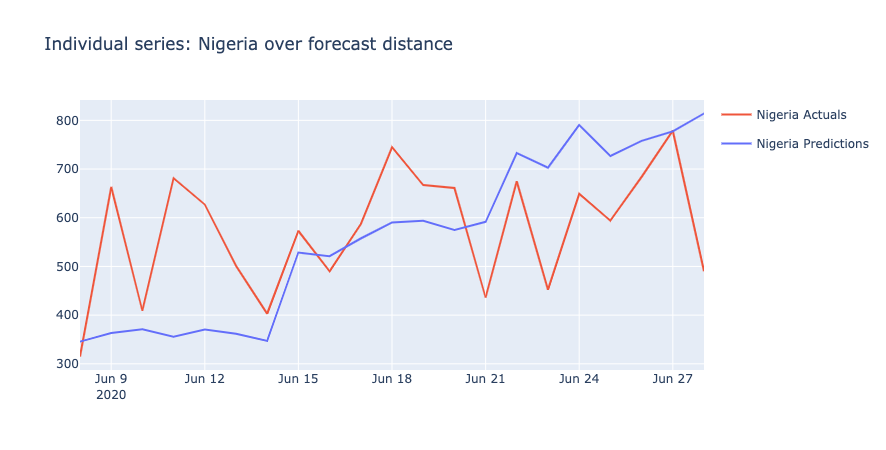

In [80]:
# plot a specific series by name: 'Nigeria'
# plot only the last 15 fds (fd_range= (16,30))
ts.plot_preds_and_actuals(covid_w_clusters, projects2_best, ts_settings, fd_range= (16, 30), fd_agg= 'mean', fd= None, average= False, series_name= 'Nigeria', top=False, data_subset= 'allBacktests', include_blenders=True, metric= 'RMSE', acc_calc=ts.rmse)

----------------
# Getting predictions from undeployed models

### First, lets create the scoring file to use, including providing the values for KIAs or ffill

In [55]:
# in this case we already have the data and KIAs, but this shows the idea
FP = pd.to_datetime('06-03-2020')
max_date = FP + pd.DateOffset(50) # the max forecast distance used
orig_max = covid_w_clusters['Date'].max() + pd.DateOffset(1)
scoring_data = covid_w_clusters[covid_w_clusters['Date'] >= FP]
scoring_data['Date'] = pd.to_datetime(scoring_data['Date'])

# in case there are any missing KIAs
scoring_data[ts_settings['known_in_advance']] = scoring_data[ts_settings['known_in_advance']].fillna(method= 'ffill')


print(scoring_data.shape)
for series in scoring_data[ts_settings['series_id']].unique():
    new_dates = pd.DataFrame({'Date': pd.date_range(start= orig_max, end= max_date), 
                              ts_settings['series_id']: series,
                            'Cluster':scoring_data[scoring_data[ts_settings['series_id']] == series]['Cluster'].max()})
    scoring_data = scoring_data.append(new_dates)
    scoring_data[ts_settings['known_in_advance']] = scoring_data[ts_settings['known_in_advance']].fillna(method= 'ffill')

scoring_data.sort_values([ts_settings['series_id'], ts_settings['date_col']], inplace= True)
scoring_data[ts_settings['known_in_advance']] = scoring_data[ts_settings['known_in_advance']].fillna(method= 'ffill')

print(scoring_data.shape)


(510, 48)
(765, 48)


In [56]:
# for clustered projects, you need to create a cluster-series mapping dict
# create a dictionary to add cluster labels for series
# if we have new series at this point, we would need to choose a cluster to manually assign the series into
clusters_to_series_dict = ts.clusters_to_series(covid_w_clusters, ts_settings)

In [57]:
projects2_best

[Project(COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-28_Cluster-3),
 Project(COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-15_Cluster-3),
 Project(COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-7_Cluster-3),
 Project(COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-28_Cluster-2),
 Project(COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-28_Cluster-2),
 Project(COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-15_Cluster-2),
 Project(COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-35_Cluster-1),
 Project(COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-28_Cluster-1),
 Project(COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-28_Cluster-1)]

In [58]:
%%time
# get the top models from all projects
# specify the validation period of interest
models_best = ts.get_top_models_from_projects(projects2_best, n_models=1, data_subset='holdout', include_blenders=True, metric='RMSE')

models_best

CPU times: user 1.52 s, sys: 30.1 ms, total: 1.55 s
Wall time: 1min 45s


[DatetimeModel('Per Series seasonal AUTOARIMA'),
 DatetimeModel('Performance Clustered eXtreme Gradient Boosted Trees Regressor'),
 DatetimeModel('Performance Clustered eXtreme Gradient Boosted Trees Regressor'),
 DatetimeModel('eXtreme Gradient Boosted Trees Regressor using Linearly Decaying Weights'),
 DatetimeModel('Ridge Regressor using Linearly Decaying Weights with Forecast Distance Modeling'),
 DatetimeModel('eXtreme Gradient Boosted Trees Regressor'),
 DatetimeModel('Per Series Elastic Net Regressor with Forecast Distance Modeling'),
 DatetimeModel('Performance Clustered Elastic Net Regressor with Forecast Distance Modeling'),
 DatetimeModel('Ridge Regressor with Forecast Distance Modeling')]

In [59]:
# we need to get stats about the projects
stats = ts.get_project_stats(projects= projects2_best, 
                          n_models= 1, 
                          cluster_to_series_map= clusters_to_series_dict,
                          models= models_best, 
                          metric=None, 
                          split_col='Cluster', 
                          prefix='COVID_cases_clustered_tutorial_2', 
                          data_subset= 'allBacktests')

In [60]:
stats

Project_Name  \
0  COVID_cases_clustered_tutorial_2_FD:11-20_FDW:...   
1  COVID_cases_clustered_tutorial_2_FD:21-30_FDW:...   
2  COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-...   
3  COVID_cases_clustered_tutorial_2_FD:21-30_FDW:...   
4  COVID_cases_clustered_tutorial_2_FD:11-20_FDW:...   
5  COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-...   
6  COVID_cases_clustered_tutorial_2_FD:11-20_FDW:...   
7  COVID_cases_clustered_tutorial_2_FD:21-30_FDW:...   
8  COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-...   

                 Project_ID Cluster     FD  FDW  \
0  5f6d127addc1ac0323176fbd       3  11-20  -28   
1  5f6d109174945902f42162e4       3  21-30  -15   
2  5f6d0bb87494590257216481       3   1-10   -7   
3  5f6d07a074945901dc2164c8       2  21-30  -28   
4  5f6d06b7ddc1ac01d017713f       2  11-20  -28   
5  5f6d030eddc1ac01d0177133       2   1-10  -15   
6  5f6cfd8574945901dc21649e       1  11-20  -35   
7  5f6cfa68ddc1ac02a3177140       1  21-30  -28   
8  5f6cf7acddc1ac02a3177130       1   1-10  -28   

                                          Model_Type  \
0                      Per Series seasonal AUTOARIMA   
1  Performance Clustered eXtreme Gradient Boosted...   
2  Performance Clustered eXtreme Gradient Boosted...   
3  eXtreme Gradient Boosted Trees Regressor using...   
4  Ridge Regressor using Linearly Decaying Weight...   
5           eXtreme Gradient Boosted Trees Regressor   
6  Per Series Elastic Net Regressor with Forecast...   
7  Performance Clustered Elastic Net Regressor wi...   
8    Ridge Regressor with Forecast Distance Modeling   

                   Model_ID                                             Series  
0  5f715136083a302119e2445f                                     [Italy, Spain]  
1  5f715168083a302119e2448c                                     [Italy, Spain]  
2  5f6d0d9205c7c96ae0da23c1                                     [Italy, Spain]  
3  5f7151cb9a117b216d2d8431                                          [Germany]  
4  5f7151de083a302149e241f5                                          [Germany]  
5  5f7151f4684b972160f42195                                          [Germany]  
6  5f71523f083a302149e242c5  [Algeria, Cameroon, Djibouti, Egypt, France, G...  
7  5f71525e684b972182f42247  [Algeria, Cameroon, Djibouti, Egypt, France, G...  
8  5f6e498d684b971241f42034  [Algeria, Cameroon, Djibouti, Egypt, France, G...

In [61]:
%%time
# get predictions from undeployed models
test_training_preds = ts.get_or_request_predictions(models= models_best, # for a deployment, no models need to be specified
                                   project_stats= stats, 
                                   scoring_df= scoring_data, # since all of the scoring rows needed are in the training_df
                                   training_df= covid_w_clusters,
                                   ts_settings= ts_settings,
                                   deployments= None, # instead specify a list of deployment objects
                                   start_date= None, 
                                   end_date= None, 
                                   forecast_point= FP)


DatetimeModel('Per Series seasonal AUTOARIMA')
For series:  ['Italy', 'Spain']
Training Data Start Date:  2020-03-25
Training Data End Date:  2020-06-19
FDW start for predictions:  2020-05-06
FDW end for predictions:  2020-06-03
Forecast point:  2020-06-03
*** Values required to generate FDW for predictions are missing from the scoring_df and will be added from the training_df ***
Adding historical data from 2020-05-06 to 2020-06-03
Uploading scoring dataset with 158 rows for Project COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-28_Cluster-3
*** Missing values were detected in the KIA variables, and were filled using backward-fill ***

DatetimeModel('Performance Clustered eXtreme Gradient Boosted Trees Regressor')
For series:  ['Italy', 'Spain']
Training Data Start Date:  2020-03-25
Training Data End Date:  2020-06-19
FDW start for predictions:  2020-05-19
FDW end for predictions:  2020-06-03
Forecast point:  2020-06-03
*** Values required to generate FDW for predictions are missing 

In [62]:
merged = ts.merge_preds_and_actuals(test_training_preds, scoring_data, ts_settings)

In [63]:
merged.head()

series_id  forecast_distance               forecast_point  prediction  \
0     Italy                 11  2020-06-03T00:00:00.000000Z  218.674473   
1     Italy                 12  2020-06-03T00:00:00.000000Z   93.593960   
2     Italy                 13  2020-06-03T00:00:00.000000Z  220.830916   
3     Italy                 14  2020-06-03T00:00:00.000000Z  235.528063   
4     Italy                 15  2020-06-03T00:00:00.000000Z  245.233083   

  original_format_timestamp  row_id  timestamp Country/Region  \
0                2020-06-14      31 2020-06-14          Italy   
1                2020-06-15      32 2020-06-15          Italy   
2                2020-06-16      33 2020-06-16          Italy   
3                2020-06-17      34 2020-06-17          Italy   
4                2020-06-18      35 2020-06-18          Italy   

   Cumulative_cases  Cumulative_deaths  Daily_cases  Daily_deaths  \
0          236989.0            34345.0        338.0          44.0   
1          237290.0            34371.0        301.0          26.0   
2          237500.0            34405.0        210.0          34.0   
3          237828.0            34448.0        328.0          43.0   
4          238159.0            34514.0        331.0          66.0   

        DataLevel       Date  Province/State  Confirmed_cases_change  \
0  Country/Region 2020-06-14             NaN               -0.023121   
1  Country/Region 2020-06-15             NaN               -0.109467   
2  Country/Region 2020-06-16             NaN               -0.302326   
3  Country/Region 2020-06-17             NaN                0.561905   
4  Country/Region 2020-06-18             NaN                0.009146   

   Cumulative_cases_change  Confirmed_deaths_change  Cumulative_deaths_change  \
0                 0.001428                -0.435897                  0.001283   
1                 0.001270                -0.409091                  0.000757   
2                 0.000885                 0.307692                  0.000989   
3                 0.001381                 0.264706                  0.001250   
4                 0.001392                 0.534884                  0.001916   

   retail_and_recreation_percent_change_from_baseline  \
0                                             -497.0    
1                                             -380.0    
2                                             -337.0    
3                                             -344.0    
4                                             -303.0    

   grocery_and_pharmacy_percent_change_from_baseline  \
0                                             -447.0   
1                                             -220.0   
2                                             -150.0   
3                                             -161.0   
4                                             -168.0   

   parks_percent_change_from_baseline  \
0                               813.0   
1                               347.0   
2                               607.0   
3                               532.0   
4                               807.0   

   transit_stations_percent_change_from_baseline  \
0                                         -415.0   
1                                         -638.0   
2                                         -591.0   
3                                         -586.0   
4                                         -538.0   

   workplaces_percent_change_from_baseline  \
0                                     33.0   
1                                   -573.0   
2                                   -565.0   
3                                   -557.0   
4                                   -561.0   

   residential_percent_change_from_baseline  Latest_Population_total  \
0                                       4.0               60421760.0   
1                                     138.0               60421760.0   
2                                     147.0               60421760.0   
3                   

------
# Deploying models and getting full scoring predictions from deployed models



In [64]:
test_deployments = ts.deploy_models(models_best)

Deployment of Per Series seasonal AUTOARIMA into COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-28_Cluster-3 successful!
Deployment of Performance Clustered eXtreme Gradient Boosted Trees Regressor into COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-15_Cluster-3 successful!
Deployment of Performance Clustered eXtreme Gradient Boosted Trees Regressor into COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-7_Cluster-3 successful!
Deployment of eXtreme Gradient Boosted Trees Regressor using Linearly Decaying Weights into COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-28_Cluster-2 successful!
Deployment of Ridge Regressor using Linearly Decaying Weights with Forecast Distance Modeling into COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-28_Cluster-2 successful!
Deployment of eXtreme Gradient Boosted Trees Regressor into COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-15_Cluster-2 successful!
Deployment of Per Series Elastic Net Regressor with Forecast Distance Modeling into COVID_cases_clustered_t

In [65]:
test_deployments

[Deployment(COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-28_Cluster-3),
 Deployment(COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-15_Cluster-3),
 Deployment(COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-7_Cluster-3),
 Deployment(COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-28_Cluster-2),
 Deployment(COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-28_Cluster-2),
 Deployment(COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-15_Cluster-2),
 Deployment(COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-35_Cluster-1),
 Deployment(COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-28_Cluster-1),
 Deployment(COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-28_Cluster-1)]

In [68]:
%%time
# get predictions from undeployed models
test_deployed_preds = ts.get_or_request_predictions(models= None, # for a deployment, no models need to be specified
                                   project_stats= stats, 
                                   scoring_df= scoring_data, # since all of the scoring rows needed are in the training_df
                                   training_df= covid_w_clusters,
                                   ts_settings= ts_settings,
                                   deployments= test_deployments, # instead specify a list of deployment objects
                                   start_date= None, 
                                   end_date= None, 
                                   forecast_point=FP)

Accessing model from COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-28_Cluster-3 deployment
Accessing model from COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-15_Cluster-3 deployment
Accessing model from COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-7_Cluster-3 deployment
Accessing model from COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-28_Cluster-2 deployment
Accessing model from COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-28_Cluster-2 deployment
Accessing model from COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-15_Cluster-2 deployment
Accessing model from COVID_cases_clustered_tutorial_2_FD:11-20_FDW:-35_Cluster-1 deployment
Accessing model from COVID_cases_clustered_tutorial_2_FD:21-30_FDW:-28_Cluster-1 deployment
Accessing model from COVID_cases_clustered_tutorial_2_FD:1-10_FDW:-28_Cluster-1 deployment

DatetimeModel('Per Series seasonal AUTOARIMA')
For series:  ['Italy', 'Spain']
Training Data Start Date:  2020-03-25
Training Data End Date:  2020-06-19
FDW start for predicti

In [69]:
test_deployed_preds.head()

series_id  forecast_distance               forecast_point  prediction  \
0     Italy                 11  2020-06-03T00:00:00.000000Z  218.674473   
1     Italy                 12  2020-06-03T00:00:00.000000Z   93.593960   
2     Italy                 13  2020-06-03T00:00:00.000000Z  220.830916   
3     Italy                 14  2020-06-03T00:00:00.000000Z  235.528063   
4     Italy                 15  2020-06-03T00:00:00.000000Z  245.233083   

  original_format_timestamp  row_id                    timestamp  
0                2020-06-14      31  2020-06-14T00:00:00.000000Z  
1                2020-06-15      32  2020-06-15T00:00:00.000000Z  
2                2020-06-16      33  2020-06-16T00:00:00.000000Z  
3                2020-06-17      34  2020-06-17T00:00:00.000000Z  
4                2020-06-18      35  2020-06-18T00:00:00.000000Z

In [70]:
%%time
preds_and_actuals = ts.merge_preds_and_actuals(test_deployed_preds, scoring_data, ts_settings)
undeployed_error = ts.rmse(merged['prediction'],merged[ts_settings['target']])
deployed_error = ts.rmse(preds_and_actuals['prediction'],preds_and_actuals[ts_settings['target']])

print('Undeployed RMSE: ',undeployed_error)
print('Deployed RMSE: ',deployed_error)

Undeployed RMSE:  467.2038442539953
Deployed RMSE:  467.2038442539953
CPU times: user 10.2 ms, sys: 2.01 ms, total: 12.2 ms
Wall time: 11.1 ms


--------
# But wait, there's more...

### This tutorial provides an overview of the basic functionality of the ts_helpers package.
### If you'd like a more thorough tutorial, check out the demand forecasting series of tutorials that provide a comprehensive instructional of the use of all of the functions.
--------